# COMP4318/5318 Assignment 2: Image Classification

### Group number: 77, SID1: 540969766, SID2: 540798188, SID3:  , SID4: 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [23]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [24]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [25]:
# Check the shape of the dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


### Preprocessing

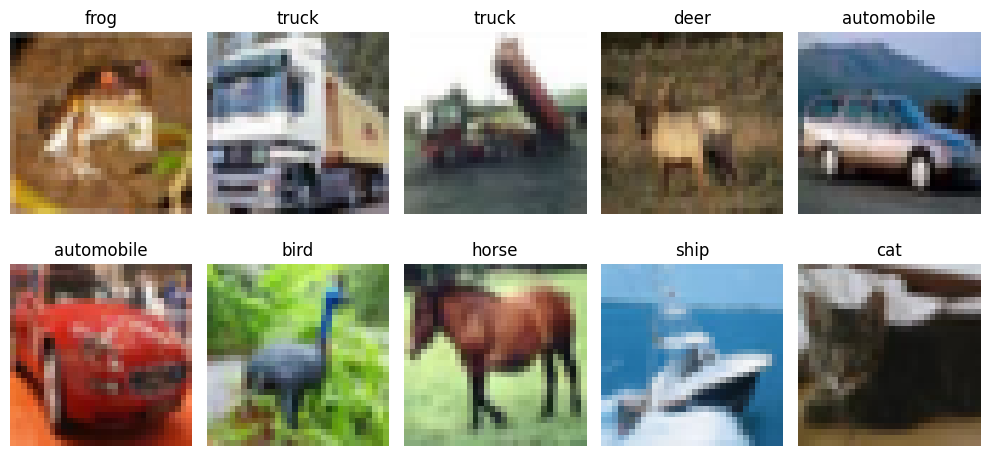

In [26]:
# Plot some examples of the dataset with labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
# Check the model's performance with subset of the whole dataset

# Flatten the labels for classical models
y_train = y_train.flatten()
y_test = y_test.flatten()

label_counts = pd.Series(y_train).value_counts().sort_index()
print(f"Label counts: {label_counts}\n\n")

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=2000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=400, stratify=y_test, random_state=42
)
# Normalize images for neural networks
X_small_norm = X_small.astype("float32") / 255.0
X_test_small_norm = X_test_small.astype("float32") / 255.0

X_small_norm = X_train_norm[:2000]
y_small_cat = y_train_cat[:2000]
X_test_small_norm = X_test_norm[:400]
y_test_small_cat = y_test_cat[:400]

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Label counts: 0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


Reduced classical training shape: (2000, 3072)
Reduced classical test shape: (400, 3072)


In [28]:
X_small_norm.shape

(2000, 32, 32, 3)

In [29]:
# Data Augmentation to introduce more variation in the training data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

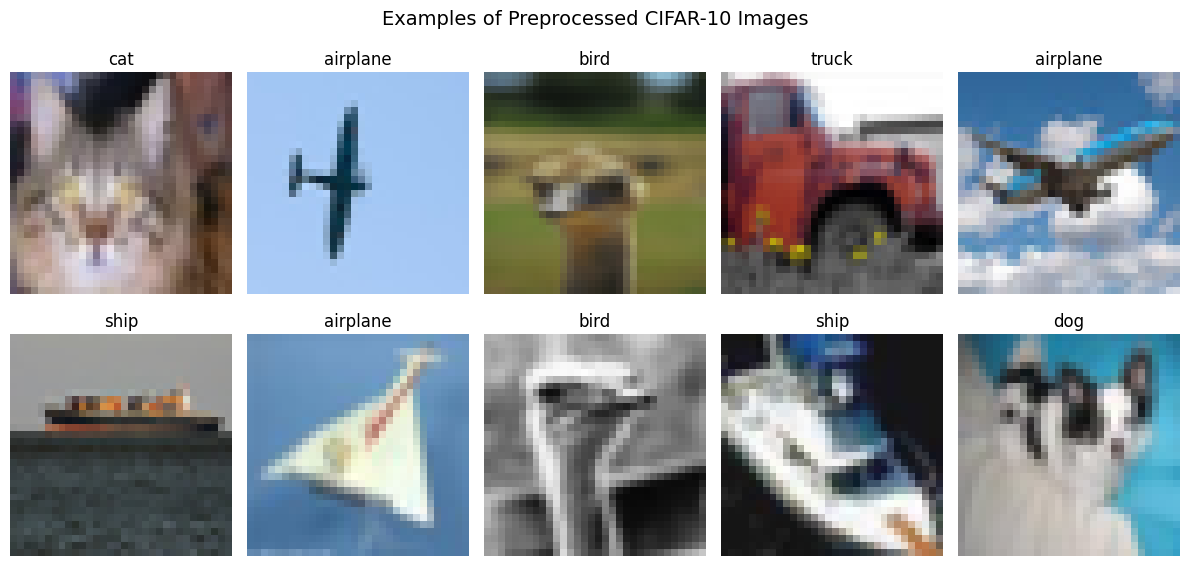

In [30]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [31]:
class ClassificationModel:

    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=42) 
        hyperparameter = {"model__C": [0.1, 1.0], "model__max_iter": [500, 1000]}
        return log_reg, hyperparameter
    def svm(self):
        svm = SVC(random_state=42)
        hyperparameter = {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]}
        return svm, hyperparameter
    def decision_tree(self):
        dt = DecisionTreeClassifier(random_state=42)
        hyperparameter = {"model__max_depth": [5, 10, 20, None], "model__min_samples_split": [2, 5, 10]}
        return dt, hyperparameter
    
    def random_forest(self, n_estimators = None, max_depth = None, min_samples_leaf = None, bootstrap = True):
        rf = RandomForestClassifier(random_state=42)
        hyperparameter = {"model__n_estimators":[50, 100, 200] if n_estimators == None else n_estimators,
                           "model__max_depth": [5, 10, 20, 30] if max_depth == None else max_depth,
                           "model__min_samples_leaf": [2, 5, 10] if min_samples_leaf == None else min_samples_leaf}
                        #    "model__bootstrap": [True] if bootstrap == True else [True, False]}
        return rf, hyperparameter
    
    def ada_boost(self):
        adb = AdaBoostClassifier(random_state=42, algorithm='SAMME')
        hyperparameter = {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]}
        return adb, hyperparameter
    
    def gradient_boost(self):
        gb = GradientBoostingClassifier(random_state=42)
        hyperparameter = {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [1, 3]
        }
        return gb, hyperparameter
    
    def bagging(self):
        bag = BaggingClassifier()
        hyperparameter = {"model__n_estimators": [50, 100]}
        return bag, hyperparameter
    
    def naivebayes(self):
        nb = GaussianNB()
        hyperparameter = {}
        return nb, hyperparameter
    
    def cnn(self, filters1=32, filters2=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, **kwargs):
        model = Sequential([
            Conv2D(filters1, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(32,32,3)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2)),

            Conv2D(filters2, (kernel_size, kernel_size), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2)),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout_rate),
            Dense(10, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def mlp(self, hidden_units=512, dropout_rate=0.3, learning_rate=0.001):
        model = Sequential([
            Flatten(input_shape=(32, 32, 3)),
            Dense(hidden_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(hidden_units // 2, activation='relu'),
            Dropout(dropout_rate / 2),
            Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
        
    def run_model(self, model,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               verbose=1):
        """
        Train and evaluate a single model (optionally with PCA), without hyperparameter tuning.

        Args:
            model: sklearn estimator
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline
            test_acc: test accuracy
        """

        # --- Ensure labels are integers ---
        y_train_int = y_train.argmax(axis=1) if y_train.ndim > 1 and y_train.shape[1] > 1 else y_train
        y_test_int  = y_test.argmax(axis=1)  if y_test.ndim > 1 and y_test.shape[1] > 1 else y_test

        # --- Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Train ---
        pipe.fit(X_train, y_train_int)

        # --- Predict ---
        y_pred_labels = pipe.predict(X_test)

        # --- Metrics ---
        accuracy_val = accuracy_score(y_test_int, y_pred_labels)
        f1_val       = f1_score(y_test_int, y_pred_labels, average='macro')

        if verbose:
            print(f"Model trained. Accuracy = {accuracy_val:.4f}, F1-score = {f1_val:.4f}")

        return pipe, accuracy_val, f1_val
    
    def tune_model(self, model, param_grid,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               cv_folds=10, verbose=1):
        """
        Train/tune a single model (optionally with PCA) using GridSearchCV.

        Args:
            model: sklearn estimator
            param_grid (dict): grid for GridSearchCV (can be empty for no tuning)
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            cv_folds (int): number of CV folds
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline (best estimator)
            test_acc: test accuracy
        """

        # --- Step 1: Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Step 2: Check if tuning is needed ---
        if not param_grid:
            pipe.fit(X_train, y_train)
            acc = accuracy_score(y_test, pipe.predict(X_test))
            print(f"Model trained without tuning. Test Accuracy = {acc:.4f}")
            return pipe, acc

        # --- Step 3: GridSearchCV ---
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv_folds,
            n_jobs=-1,
            scoring="accuracy",
            verbose=verbose
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        # --- Step 4: Evaluate ---
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        print(f"Best Params = {search.best_params_}, Test Accuracy = {test_acc:.4f}")

        return best_model, test_acc

        
classification_model = ClassificationModel()



### Fully connected neural network

In [32]:

mlp_base = KerasClassifier(
    model=classification_model.mlp(),
    epochs=50,
    batch_size=64,
    verbose=1
)

# --- Train (using small normalized dataset) ---
mlp_base.fit(X_small_norm, y_small_cat, validation_data=(X_test_small_norm, y_test_small_cat))

# Predict on small test set
y_pred = mlp_base.predict(X_test_small_norm)

# Convert one-hot true labels to integer
y_true = y_test_small_cat.argmax(axis=1)

# If predictions are probabilities, convert to class index
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

# Compute metrics
mlp_acc = accuracy_score(y_true, y_pred)
mlp_f1 = f1_score(y_true, y_pred, average='macro')  # use y_true, not y_test
print(f"✅ Test Accuracy: {mlp_acc:.4f}, F1-score: {mlp_f1:.4f}")


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1200 - loss: 2.9521 - val_accuracy: 0.1925 - val_loss: 2.1686
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1927 - loss: 2.1756 - val_accuracy: 0.2500 - val_loss: 2.1144
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2454 - loss: 2.1018 - val_accuracy: 0.1825 - val_loss: 2.0765
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2369 - loss: 2.0373 - val_accuracy: 0.3125 - val_loss: 1.9946
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2703 - loss: 1.9997 - val_accuracy: 0.3300 - val_loss: 1.9581
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2913 - loss: 1.9523 - val_accuracy: 0.2800 - val_loss: 1.9884
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2957 - loss: 1.9512 - val_accuracy: 0.2975 - val_loss: 1.9779
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2854 - loss: 1.9196 - val_accuracy: 0.2975 - val_loss:

### Convolutional neural network

In [33]:
cnn = classification_model.cnn()

cnn_base = KerasClassifier(
    model=cnn,
    epochs=20,
    batch_size=64,
    verbose=1
)
# Compile CNN
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

cnn.summary()


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,482 (2.08 MB)

 Trainable params: 545,290 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [34]:
cnn_base = KerasClassifier(
    model=cnn,
    epochs=50,
    batch_size=64,
    verbose=1
)
cnn_base.fit(
    X_small_norm, y_small_cat,
    validation_data=(X_test_small_norm, y_test_small_cat)
)

# Predict on small test set
y_pred = cnn_base.predict(X_test_small_norm)

# Convert one-hot true labels to integers
y_true = y_test_small_cat.argmax(axis=1)

# If predictions are probabilities, convert to class index
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

# Compute metrics
cnn_acc = accuracy_score(y_true, y_pred)
cnn_f1 = f1_score(y_true, y_pred, average='macro')  # use y_true, not y_test
print(f"✅ CNN Base Test Accuracy: {cnn_acc:.4f}, F1-score: {cnn_f1:.4f}")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2318 - loss: 2.8597 - precision: 0.2760 - recall: 0.1029 - val_accuracy: 0.1375 - val_loss: 2.2149 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3918 - loss: 1.7029 - precision: 0.5871 - recall: 0.1726 - val_accuracy: 0.1750 - val_loss: 2.3233 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4458 - loss: 1.5118 - precision: 0.6833 - recall: 0.2422 - val_accuracy: 0.1750 - val_loss: 2.9464 - val_precision: 0.2647 - val_recall: 0.0900
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5438 - loss: 1.2568 - precision: 0.7245 - recall: 0.3315 - val_accuracy: 0.1675 - val_loss: 4.0446 - val_precision: 0.1951 - val_recall: 0.1400
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5960 - loss: 1.1156 - precision: 0.7246 - recall: 0.4470 - val_accuracy: 0.0900 - v

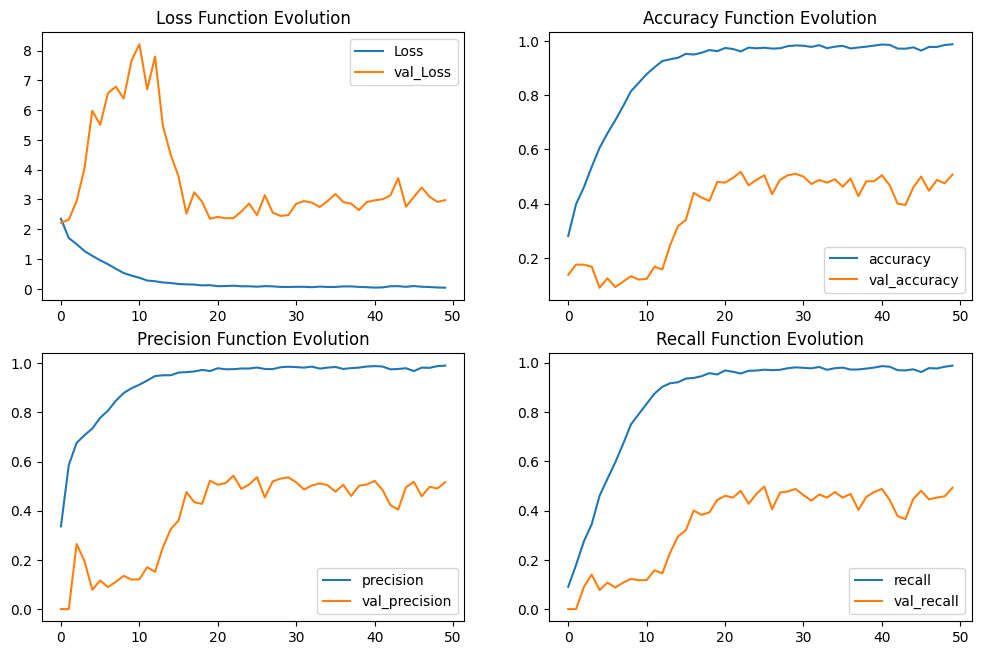

In [35]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(cnn_base.history_['loss'], label='Loss')
plt.plot(cnn_base.history_['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(cnn_base.history_['accuracy'], label='accuracy')
plt.plot(cnn_base.history_['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(cnn_base.history_['precision'], label='precision')
plt.plot(cnn_base.history_['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(cnn_base.history_['recall'], label='recall')
plt.plot(cnn_base.history_['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


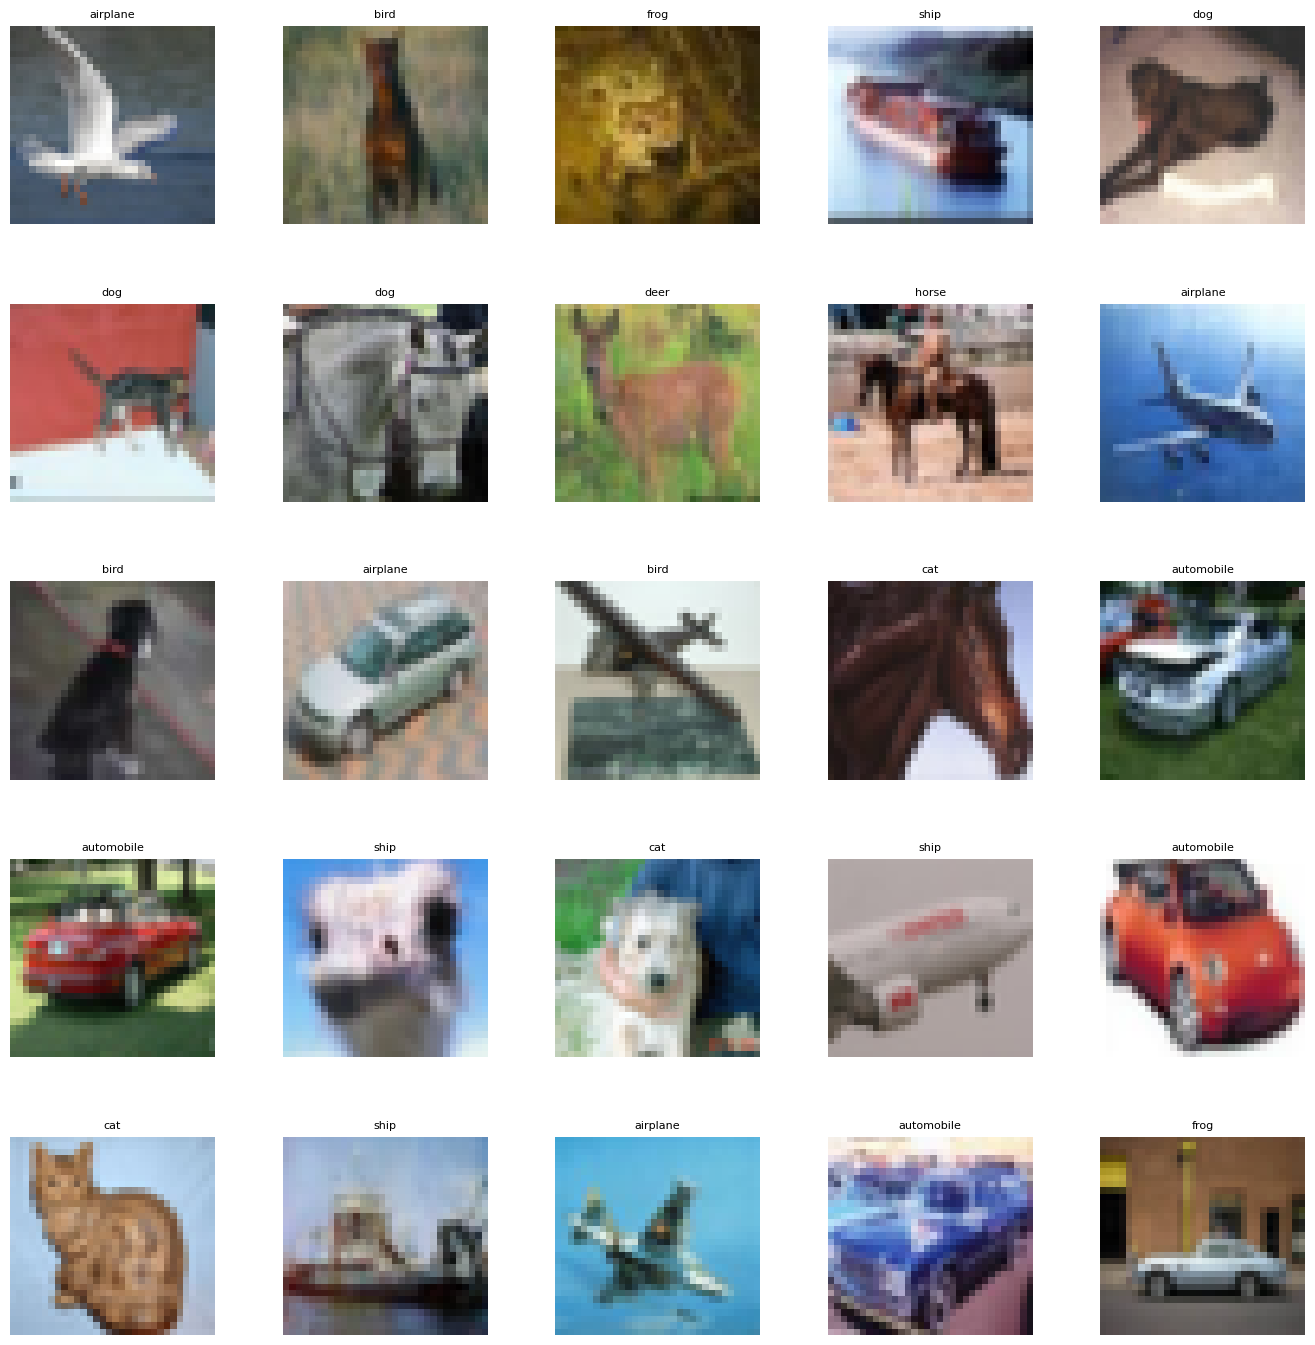

In [36]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_pred = cnn.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)

# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [37]:
# Define base models
models = {
    "Logistic Regression": classification_model.logistic_regression()[0],
    "SVM": classification_model.svm()[0],
    "Decision Tree": classification_model.decision_tree()[0],
    "Random Forest": classification_model.random_forest()[0],
    "AdaBoost": classification_model.ada_boost()[0],
    "Gradient Boosting": classification_model.gradient_boost()[0],
    "Bagging": classification_model.bagging()[0],
    "Naive Bayes": classification_model.naivebayes()[0]
}

use_pca_flags = {
    "Logistic Regression": False,
    "SVM": False,
    "Decision Tree": False,
    "Random Forest": False,
    "AdaBoost": False,
    "Gradient Boosting": True,
    "Bagging": False,
    "Naive Bayes": False
}

tuned_results = {}
best_models = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    use_pca = use_pca_flags.get(name, False)
    
    pipe, test_acc, test_f1 = classification_model.run_model(
        model=model,
        X_train=X_small,
        y_train=y_small,
        X_test=X_test_small,
        y_test=y_test_small,
        use_pca=use_pca,
        n_components=0.95
    )

    tuned_results[name] = {"accuracy": test_acc, "f1_score": test_f1}

    

print(f"\nOverall performance of the models: {tuned_results}")


 Training Logistic Regression...
Model trained. Accuracy = 0.2825, F1-score = 0.2837

 Training SVM...
Model trained. Accuracy = 0.4175, F1-score = 0.4104

 Training Decision Tree...
Model trained. Accuracy = 0.2300, F1-score = 0.2280

 Training Random Forest...
Model trained. Accuracy = 0.4075, F1-score = 0.3990

 Training AdaBoost...


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Model trained. Accuracy = 0.2225, F1-score = 0.2164

 Training Gradient Boosting...
Model trained. Accuracy = 0.3850, F1-score = 0.3830

 Training Bagging...
Model trained. Accuracy = 0.3125, F1-score = 0.3063

 Training Naive Bayes...
Model trained. Accuracy = 0.3150, F1-score = 0.2812

Overall performance of the models: {'Logistic Regression': {'accuracy': 0.2825, 'f1_score': 0.2837371650056725}, 'SVM': {'accuracy': 0.4175, 'f1_score': 0.41042169654066124}, 'Decision Tree': {'accuracy': 0.23, 'f1_score': 0.22797452168611473}, 'Random Forest': {'accuracy': 0.4075, 'f1_score': 0.39898999471076185}, 'AdaBoost': {'accuracy': 0.2225, 'f1_score': 0.21641246837862432}, 'Gradient Boosting': {'accuracy': 0.385, 'f1_score': 0.38296367422502586}, 'Bagging': {'accuracy': 0.3125, 'f1_score': 0.306340127021952}, 'Naive Bayes': {'accuracy': 0.315, 'f1_score': 0.281150203613264}}


In [38]:
tuned_results['CNN'] = {"accuracy": cnn_acc, "f1_score": cnn_f1}
tuned_results['MLP'] = {"accuracy": mlp_acc, "f1_score": mlp_f1}
# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(tuned_results, orient='index')  
results_df.index.name = 'Model'
results_df.reset_index(inplace=True)

print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                 Model  accuracy  f1_score
0  Logistic Regression    0.2825  0.283737
1                  SVM    0.4175  0.410422
2        Decision Tree    0.2300  0.227975
3        Random Forest    0.4075  0.398990
4             AdaBoost    0.2225  0.216412
5    Gradient Boosting    0.3850  0.382964
6              Bagging    0.3125  0.306340
7          Naive Bayes    0.3150  0.281150
8                  CNN    0.5075  0.498998
9                  MLP    0.3450  0.320657


## 3. Hyperparameter tuning

In [39]:
# Helper functions for plotting
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### CNN

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


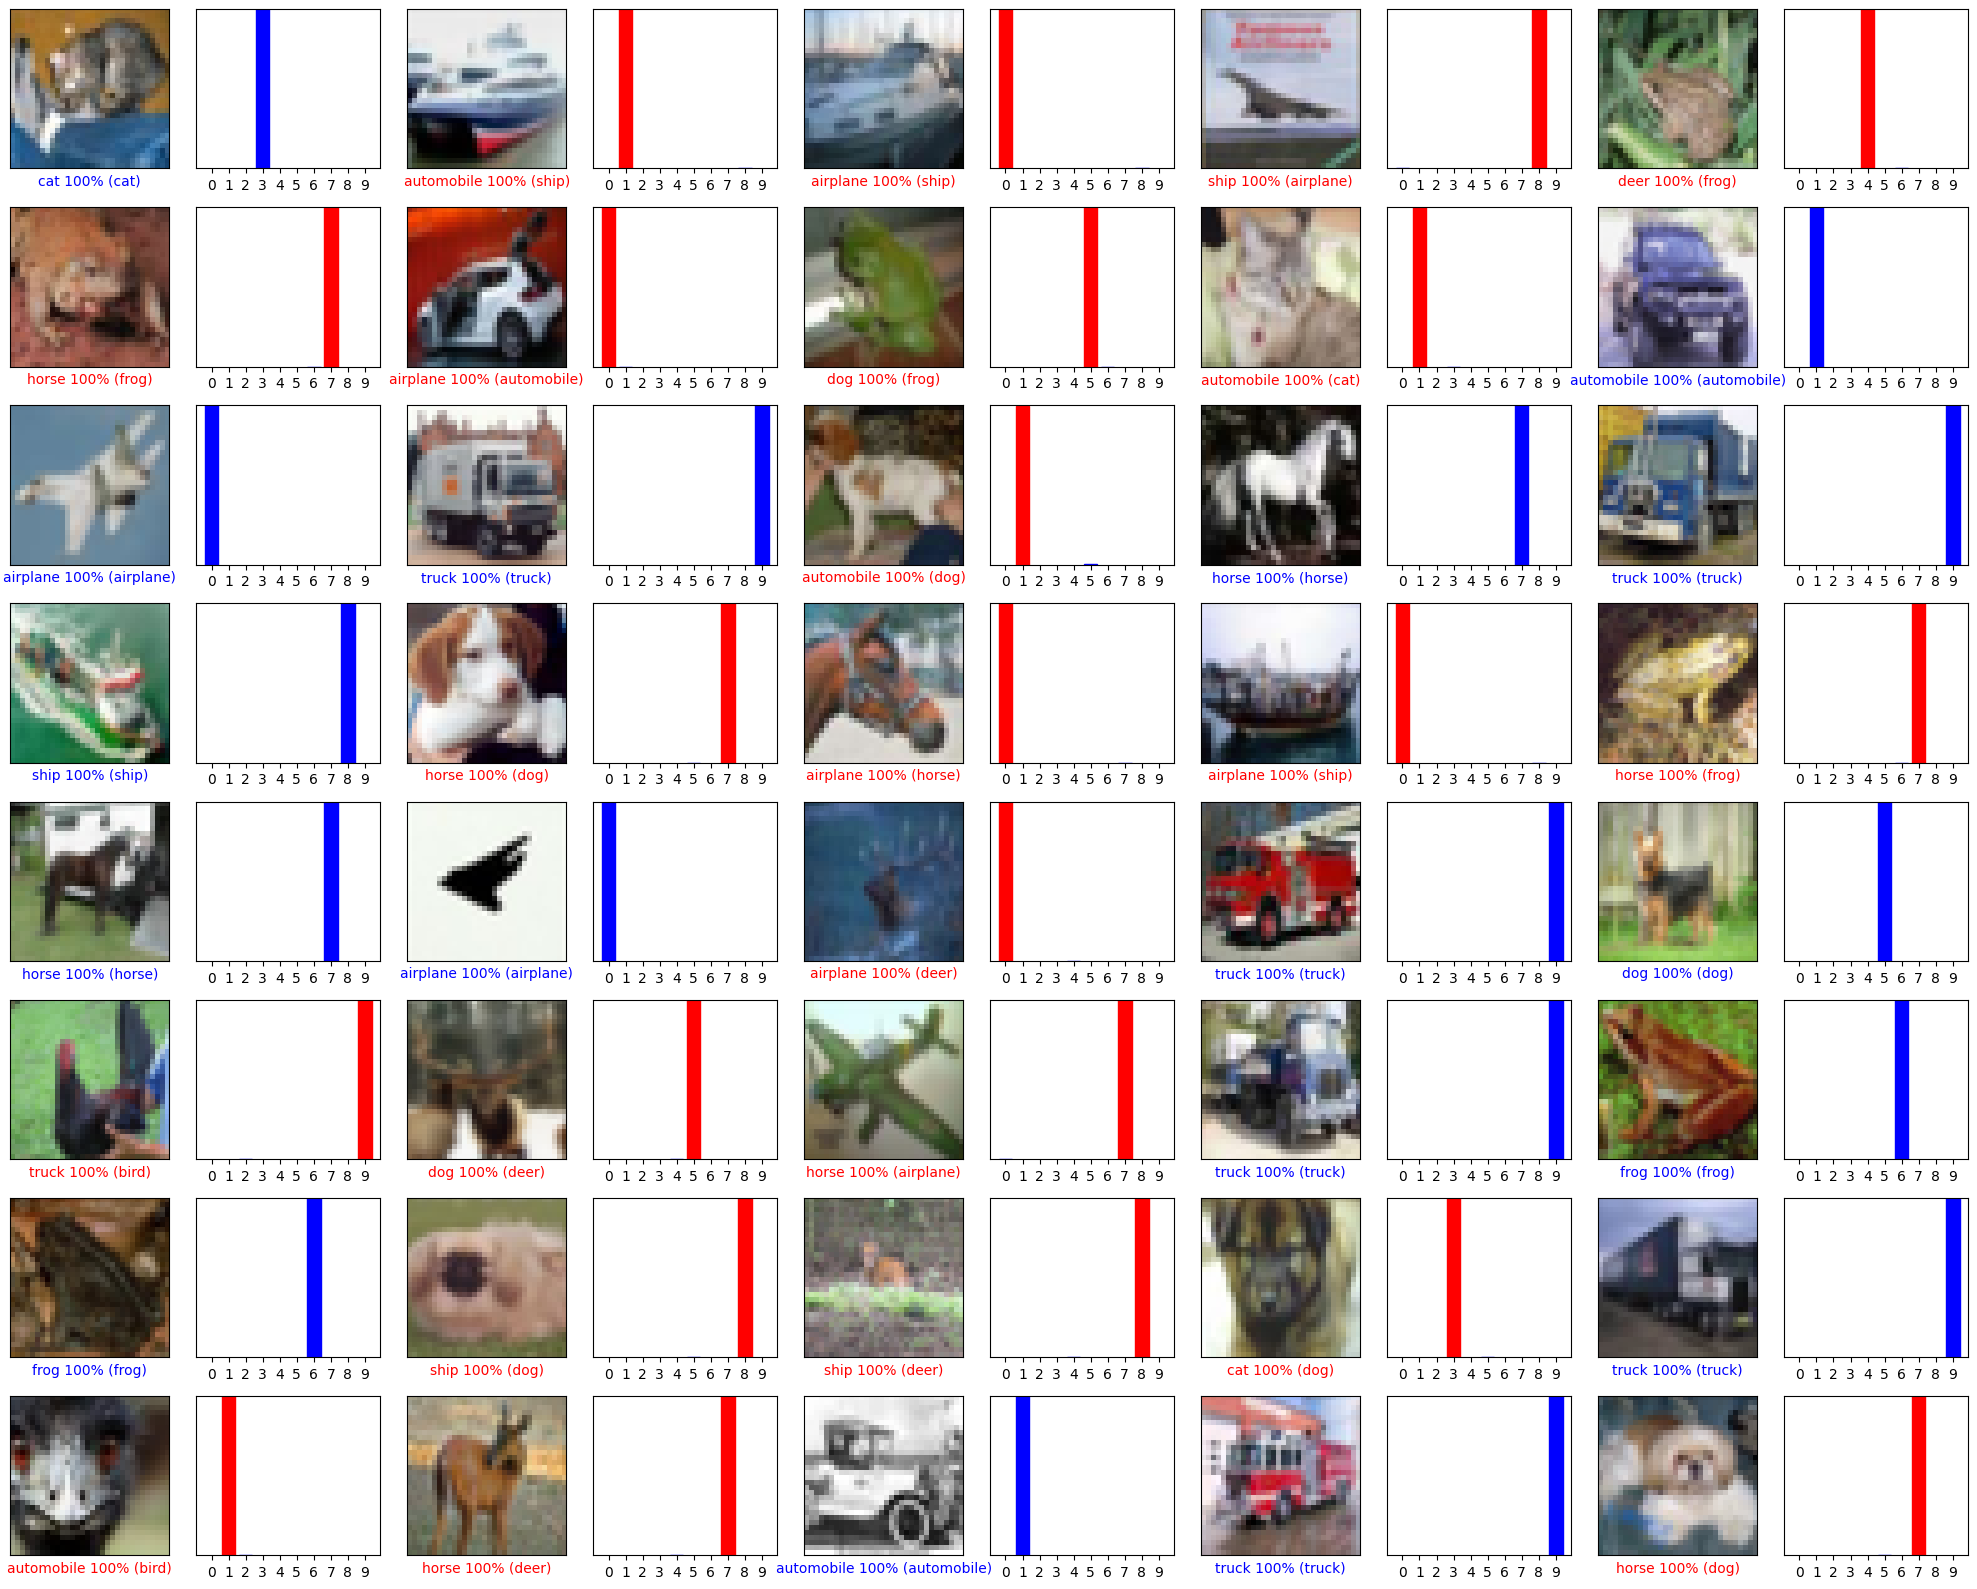

In [40]:
predictions = cnn.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

### Algorithm of choice from first six weeks of course
- Random Forest
- SVM

In [ ]:
# X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
#     X_train_flat, y_train, test_size=0.2, random_state=42
# )


model_rf = classification_model.random_forest(bootstrap=False)

# Hyperparameter tuning for Random Forest
rf  = classification_model.tune_model(model = model_rf[0], param_grid=model_rf[1], cv_folds=10, X_train = X_train_flat, y_train = y_train, X_test = X_test_flat, y_test=y_test, use_pca = False)


print(f"Accuracy: {rf[1]}, Best Parameters: {rf[0]}")
# # --- Train on a subset for speed (optional) ---
# rf.fit(X_train_rf, y_train_rf)

# # --- Predict on validation set ---
# y_pred_val = rf.predict(X_val_rf)  # smaller batch for quick test

# # --- Evaluate accuracy ---
# acc = accuracy_score(y_val_rf, y_pred_val)
# print(f"Validation Accuracy: {acc:.4f}")

In [42]:

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
batch_size = 64

train_gen = data_generator.flow(
    X_small_norm, y_small_cat,
    batch_size=batch_size
)
param_grid_cnn = {
    "filters1": [32, 64],
    "filters2": [64, 128],
    "kernel_size": [3, 5],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [15, 30]
}

keys, values = zip(*param_grid_cnn.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_acc = 0
best_params = None
best_model = None

for params in combinations:
    print("Testing params:", params)
    
    model = classification_model.cnn(
        filters1=params['filters1'],
        filters2=params['filters2'],
        kernel_size=params['kernel_size'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    # Create generator for this batch size
    train_gen = data_generator.flow(
        X_small_norm, y_small_cat,
        batch_size=params['batch_size']
    )
    
    model.fit(
        train_gen,
        steps_per_epoch=len(X_small_norm) // params['batch_size'],
        validation_data=(X_test_small_norm, y_test_small_cat),
        epochs=params['epochs'],
        verbose=0
    )
    
    y_pred = model.predict(X_test_small_norm).argmax(axis=1)
    y_true = y_test_small_cat.argmax(axis=1)
    acc = accuracy_score(y_true, y_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_params = params
        print(f"🎯 New best accuracy: {best_acc:.4f}")

print("Best CNN params:", best_params)


Testing params: {'filters1': 32, 'filters2': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15}
Epoch 1/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2160 - loss: 2.8352 - val_accuracy: 0.2100 - val_loss: 2.3012
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.3125 - loss: 2.0078 - val_accuracy: 0.2050 - val_loss: 2.3058
Epoch 3/15
13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2767 - loss: 1.9692

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3025 - loss: 1.9151 - val_accuracy: 0.1825 - val_loss: 3.0039
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.2500 - loss: 2.2321 - val_accuracy: 0.1825 - val_loss: 3.0072
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3429 - loss: 1.7744 - val_accuracy: 0.2100 - val_loss: 4.8099
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.3125 - loss: 2.0522 - val_accuracy: 0.2050 - val_loss: 4.7905
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3958 - loss: 1.6880 - val_accuracy: 0.2250 - val_loss: 3.6072
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.4062 - loss: 1.8148 - val_accuracy: 0.2225 - val_loss: 3.6153
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4154 - loss: 1.6736 - val_accuracy: 0.2450 - val_loss: 4.1253
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.3750 - loss: 1.6656 - val_accuracy: 0.2400 - val_los

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2170 - loss: 2.7708 - val_accuracy: 0.1050 - val_loss: 3.2599
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.4688 - loss: 1.8289 - val_accuracy: 0.1050 - val_loss: 3.2982
Epoch 3/30
 6/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3044 - loss: 1.8194

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3021 - loss: 1.8879 - val_accuracy: 0.1000 - val_loss: 6.4754
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.4688 - loss: 1.6130 - val_accuracy: 0.1000 - val_loss: 6.5432
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3551 - loss: 1.7451 - val_accuracy: 0.1000 - val_loss: 8.6992
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5000 - loss: 1.5605 - val_accuracy: 0.1025 - val_loss: 8.7055
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3884 - loss: 1.7096 - val_accuracy: 0.1225 - val_loss: 6.4873
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.2500 - loss: 1.6866 - val_accuracy: 0.1275 - val_loss: 6.3567
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4281 - loss: 1.5859 - val_accuracy: 0.1950 - val_loss: 4.1817
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.4062 - loss: 1.8512 - val_accuracy: 0.2000 - val_los

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1779 - loss: 3.6232 - val_accuracy: 0.1800 - val_loss: 2.2195
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2500 - loss: 2.0077 - val_accuracy: 0.1800 - val_loss: 2.2216
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2344 - loss: 2.0074

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3214 - loss: 1.8947 - val_accuracy: 0.0950 - val_loss: 3.8542
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2656 - loss: 1.9804 - val_accuracy: 0.0950 - val_loss: 3.8957
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3317 - loss: 1.8038 - val_accuracy: 0.0950 - val_loss: 5.5783
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4219 - loss: 1.5088 - val_accuracy: 0.0950 - val_loss: 5.5754
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3814 - loss: 1.7555 - val_accuracy: 0.0950 - val_loss: 7.9462
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3906 - loss: 1.6974 - val_accuracy: 0.0950 - val_loss: 7.9314
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4166 - loss: 1.6699 - val_accuracy: 0.0950 - val_loss: 8.8763
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.7789 - val_accuracy: 0.0950 - val_loss: 8.820

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2028 - loss: 2.9805 - val_accuracy: 0.1800 - val_loss: 2.2109
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3594 - loss: 1.9238 - val_accuracy: 0.1950 - val_loss: 2.2017
Epoch 3/30
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2552 - loss: 2.0678

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3117 - loss: 1.9192 - val_accuracy: 0.1400 - val_loss: 2.6213
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3594 - loss: 1.6743 - val_accuracy: 0.1400 - val_loss: 2.6774
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3839 - loss: 1.7421 - val_accuracy: 0.1325 - val_loss: 3.5882
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.7107 - val_accuracy: 0.1350 - val_loss: 3.6160
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4275 - loss: 1.6293 - val_accuracy: 0.1300 - val_loss: 4.6584
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 1.5007 - val_accuracy: 0.1325 - val_loss: 4.6757
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4224 - loss: 1.5678 - val_accuracy: 0.1250 - val_loss: 5.7462
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.6596 - val_accuracy: 0.1250 - val_loss: 5.737

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1985 - loss: 2.5095 - val_accuracy: 0.1425 - val_loss: 2.2215
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.2500 - loss: 1.9820 - val_accuracy: 0.1425 - val_loss: 2.2222
Epoch 3/15
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2674 - loss: 1.9336

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3147 - loss: 1.8893 - val_accuracy: 0.1725 - val_loss: 2.6538
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.4375 - loss: 1.8371 - val_accuracy: 0.1675 - val_loss: 2.6598
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3987 - loss: 1.7356 - val_accuracy: 0.1900 - val_loss: 3.1511
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.5312 - loss: 1.3907 - val_accuracy: 0.1875 - val_loss: 3.1436
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4019 - loss: 1.6437 - val_accuracy: 0.1600 - val_loss: 3.7130
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.3125 - loss: 1.9556 - val_accuracy: 0.1600 - val_loss: 3.7186
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4152 - loss: 1.5969 - val_accuracy: 0.2100 - val_loss: 2.6678
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.5000 - loss: 1.3371 - val_accuracy: 0.2100 - val_los

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2005 - loss: 2.6146 - val_accuracy: 0.1000 - val_loss: 2.2917
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.3125 - loss: 1.8269 - val_accuracy: 0.0950 - val_loss: 2.2956
Epoch 3/30
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3580 - loss: 1.7442

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3672 - loss: 1.7515 - val_accuracy: 0.0750 - val_loss: 3.1157
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.7347 - val_accuracy: 0.0750 - val_loss: 3.1094
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3932 - loss: 1.6350 - val_accuracy: 0.0775 - val_loss: 4.4193
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5000 - loss: 1.5877 - val_accuracy: 0.0775 - val_loss: 4.4176
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4216 - loss: 1.5969 - val_accuracy: 0.1300 - val_loss: 3.9916
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.3125 - loss: 1.6606 - val_accuracy: 0.1325 - val_loss: 3.9577
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4541 - loss: 1.5152 - val_accuracy: 0.1850 - val_loss: 3.0820
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.4375 - loss: 1.4724 - val_accuracy: 0.1950 - val_loss:

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1911 - loss: 2.7256 - val_accuracy: 0.1400 - val_loss: 2.2639
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 2.1283 - val_accuracy: 0.1425 - val_loss: 2.2631
Epoch 3/15
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2751 - loss: 1.9768

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3184 - loss: 1.8339 - val_accuracy: 0.1925 - val_loss: 2.2860
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.5427 - val_accuracy: 0.1925 - val_loss: 2.2946
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3958 - loss: 1.6885 - val_accuracy: 0.2025 - val_loss: 2.4497
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4844 - loss: 1.5211 - val_accuracy: 0.2025 - val_loss: 2.4622
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4377 - loss: 1.5715 - val_accuracy: 0.1875 - val_loss: 2.6907
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4219 - loss: 1.6912 - val_accuracy: 0.1925 - val_loss: 2.6896
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4613 - loss: 1.5127 - val_accuracy: 0.2025 - val_loss: 2.9624
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3906 - loss: 1.5564 - val_accuracy: 0.2025 - val_loss: 2.943

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2126 - loss: 2.6126 - val_accuracy: 0.2325 - val_loss: 2.2266
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3906 - loss: 1.8285 - val_accuracy: 0.2300 - val_loss: 2.2225
Epoch 3/30
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2959 - loss: 1.9056

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3306 - loss: 1.8652 - val_accuracy: 0.2000 - val_loss: 2.2459
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 2.3696 - val_accuracy: 0.2125 - val_loss: 2.2418
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3769 - loss: 1.7750 - val_accuracy: 0.1450 - val_loss: 2.6254
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.5685 - val_accuracy: 0.1450 - val_loss: 2.6604
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4369 - loss: 1.5859 - val_accuracy: 0.1400 - val_loss: 3.0764
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.6269 - val_accuracy: 0.1400 - val_loss: 3.0947
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4360 - loss: 1.5850 - val_accuracy: 0.1175 - val_loss: 3.5962
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.5968 - val_accuracy: 0.1125 - val_loss: 3.648

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2266 - loss: 2.6697 - val_accuracy: 0.1575 - val_loss: 2.2297
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 1.9526 - val_accuracy: 0.1550 - val_loss: 2.2317
Epoch 3/15
 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3665 - loss: 1.8421

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3125 - loss: 1.9516 - val_accuracy: 0.1400 - val_loss: 2.5207
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 1.9073 - val_accuracy: 0.1325 - val_loss: 2.5500
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3284 - loss: 1.8780 - val_accuracy: 0.2025 - val_loss: 2.6402
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 1.6895 - val_accuracy: 0.2125 - val_loss: 2.5725
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3935 - loss: 1.7590 - val_accuracy: 0.2775 - val_loss: 2.5888
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 1.8014 - val_accuracy: 0.2700 - val_loss: 2.7086
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3796 - loss: 1.7305 - val_accuracy: 0.2750 - val_loss: 3.2522
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 1.8864 - val_accuracy: 0.2725 - val_loss: 3.290

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2237 - loss: 2.8451 - val_accuracy: 0.1375 - val_loss: 2.3247
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.3438 - loss: 1.8204 - val_accuracy: 0.1375 - val_loss: 2.3354
Epoch 3/30
 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3235 - loss: 1.8996

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3021 - loss: 1.9330 - val_accuracy: 0.1300 - val_loss: 3.9483
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 2.1634 - val_accuracy: 0.1275 - val_loss: 3.9867
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3240 - loss: 1.8328 - val_accuracy: 0.1425 - val_loss: 5.1328
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 2.0163 - val_accuracy: 0.1450 - val_loss: 5.0754
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3546 - loss: 1.8089 - val_accuracy: 0.1525 - val_loss: 4.3596
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.7318 - val_accuracy: 0.1575 - val_loss: 4.3963
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3632 - loss: 1.6746 - val_accuracy: 0.2100 - val_loss: 3.0933
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.4963 - val_accuracy: 0.2225 - val_loss: 3.033

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2116 - loss: 3.1090 - val_accuracy: 0.2025 - val_loss: 2.2191
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2656 - loss: 2.0980 - val_accuracy: 0.1975 - val_loss: 2.2147
Epoch 3/15
 3/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3073 - loss: 1.9221

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3132 - loss: 1.9190 - val_accuracy: 0.1425 - val_loss: 2.3950
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2812 - loss: 2.1184 - val_accuracy: 0.1375 - val_loss: 2.4099
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3135 - loss: 1.8984 - val_accuracy: 0.0950 - val_loss: 3.0441
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.7847 - val_accuracy: 0.0950 - val_loss: 3.0584
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3854 - loss: 1.6624 - val_accuracy: 0.1075 - val_loss: 4.2052
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 2.0268 - val_accuracy: 0.1075 - val_loss: 4.2496
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3950 - loss: 1.6601 - val_accuracy: 0.1050 - val_loss: 4.9233
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 1.4452 - val_accuracy: 0.1075 - val_loss: 4.931

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.1911 - loss: 2.8370 - val_accuracy: 0.1675 - val_loss: 2.2454
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 1.8107 - val_accuracy: 0.1625 - val_loss: 2.2442
Epoch 3/30
 3/31 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2960 - loss: 1.8762

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2967 - loss: 1.9630 - val_accuracy: 0.1050 - val_loss: 2.8739
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.8531 - val_accuracy: 0.1050 - val_loss: 2.8990
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3233 - loss: 1.8604 - val_accuracy: 0.1050 - val_loss: 4.4410
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 1.8482 - val_accuracy: 0.1050 - val_loss: 4.5554
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3815 - loss: 1.7476 - val_accuracy: 0.1050 - val_loss: 5.3633
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3594 - loss: 1.5399 - val_accuracy: 0.1050 - val_loss: 5.4572
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3814 - loss: 1.7246 - val_accuracy: 0.1075 - val_loss: 6.3718
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4531 - loss: 1.6657 - val_accuracy: 0.1075 - val_loss: 6.488

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1899 - loss: 2.8532 - val_accuracy: 0.2100 - val_loss: 2.2299
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 1.8017 - val_accuracy: 0.2125 - val_loss: 2.2294
Epoch 3/15
 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2748 - loss: 2.0503

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3130 - loss: 1.9520 - val_accuracy: 0.1750 - val_loss: 2.3827
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.9287 - val_accuracy: 0.1725 - val_loss: 2.3918
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3651 - loss: 1.7439 - val_accuracy: 0.2075 - val_loss: 2.5629
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 2.0146 - val_accuracy: 0.2050 - val_loss: 2.5679
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3828 - loss: 1.6782 - val_accuracy: 0.2425 - val_loss: 2.3721
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 1.8526 - val_accuracy: 0.2425 - val_loss: 2.3874
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3920 - loss: 1.6783 - val_accuracy: 0.2575 - val_loss: 2.4338
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.3591 - val_accuracy: 0.2550 - val_loss: 2.446

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1976 - loss: 2.7996 - val_accuracy: 0.1725 - val_loss: 2.2861
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 2.0981 - val_accuracy: 0.1675 - val_loss: 2.2897
Epoch 3/30
 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2942 - loss: 2.0047

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3331 - loss: 1.9056 - val_accuracy: 0.1775 - val_loss: 2.6844
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 2.1000 - val_accuracy: 0.1825 - val_loss: 2.6973
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3966 - loss: 1.6960 - val_accuracy: 0.1925 - val_loss: 3.1716
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7900 - val_accuracy: 0.1925 - val_loss: 3.1574
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3827 - loss: 1.6891 - val_accuracy: 0.1875 - val_loss: 3.1780
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.6594 - val_accuracy: 0.1900 - val_loss: 3.1649
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4222 - loss: 1.6265 - val_accuracy: 0.2425 - val_loss: 2.7954
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 1.8526 - val_accuracy: 0.2500 - val_loss: 2.788

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1998 - loss: 2.7601 - val_accuracy: 0.1900 - val_loss: 2.2520
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.8361 - val_accuracy: 0.1975 - val_loss: 2.2476
Epoch 3/15
 3/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2795 - loss: 1.9515

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3177 - loss: 1.9211 - val_accuracy: 0.1300 - val_loss: 2.1805
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3594 - loss: 1.9051 - val_accuracy: 0.1250 - val_loss: 2.1831
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3687 - loss: 1.7730 - val_accuracy: 0.1050 - val_loss: 2.3301
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.7070 - val_accuracy: 0.1100 - val_loss: 2.3445
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3912 - loss: 1.7218 - val_accuracy: 0.1375 - val_loss: 2.3199
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.6240 - val_accuracy: 0.1350 - val_loss: 2.3196
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4162 - loss: 1.6538 - val_accuracy: 0.1225 - val_loss: 2.7253
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4844 - loss: 1.5718 - val_accuracy: 0.1225 - val_loss: 2.743

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1945 - loss: 2.6191 - val_accuracy: 0.2000 - val_loss: 2.2318
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2969 - loss: 2.0220 - val_accuracy: 0.2025 - val_loss: 2.2287
Epoch 3/30
 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3457 - loss: 1.8700

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3358 - loss: 1.8695 - val_accuracy: 0.2075 - val_loss: 2.2997
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.9454 - val_accuracy: 0.2100 - val_loss: 2.2999
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3639 - loss: 1.7378 - val_accuracy: 0.1825 - val_loss: 2.6815
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 1.9428 - val_accuracy: 0.1750 - val_loss: 2.6954
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3886 - loss: 1.6858 - val_accuracy: 0.2000 - val_loss: 3.1195
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3281 - loss: 1.8123 - val_accuracy: 0.1975 - val_loss: 3.1192
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4208 - loss: 1.6014 - val_accuracy: 0.1800 - val_loss: 3.9375
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.7765 - val_accuracy: 0.1775 - val_loss: 3.941

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.1955 - loss: 3.1001 - val_accuracy: 0.1300 - val_loss: 2.6729
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 2.1549 - val_accuracy: 0.1300 - val_loss: 2.7247
Epoch 3/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4375 - loss: 1.6019

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3148 - loss: 1.8851 - val_accuracy: 0.1175 - val_loss: 5.2087
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 2.0907 - val_accuracy: 0.1175 - val_loss: 5.2424
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3428 - loss: 1.7859 - val_accuracy: 0.1375 - val_loss: 5.0513
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 2.1067 - val_accuracy: 0.1500 - val_loss: 4.9395
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3918 - loss: 1.7319 - val_accuracy: 0.1900 - val_loss: 3.2555
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.7904 - val_accuracy: 0.2000 - val_loss: 3.2370
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3679 - loss: 1.7228 - val_accuracy: 0.2650 - val_loss: 3.1134
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.6184 - val_accuracy: 0.2650 - val_loss: 3.270

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1967 - loss: 2.7972 - val_accuracy: 0.1075 - val_loss: 2.7489
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 2.4570 - val_accuracy: 0.1175 - val_loss: 2.7028
Epoch 3/30
 3/62 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3490 - loss: 1.7564

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3079 - loss: 1.9155 - val_accuracy: 0.1075 - val_loss: 5.9381
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.7543 - val_accuracy: 0.1075 - val_loss: 5.9000
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3308 - loss: 1.8297 - val_accuracy: 0.1625 - val_loss: 5.3763
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 1.5966 - val_accuracy: 0.1700 - val_loss: 5.3926
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3430 - loss: 1.7981 - val_accuracy: 0.2325 - val_loss: 3.9216
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 1.6080 - val_accuracy: 0.2350 - val_loss: 4.0224
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3701 - loss: 1.7391 - val_accuracy: 0.2225 - val_loss: 3.5077
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.5317 - val_accuracy: 0.2575 - val_loss: 3.244

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.1912 - loss: 2.9645 - val_accuracy: 0.1600 - val_loss: 2.2316
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2969 - loss: 1.9905 - val_accuracy: 0.1725 - val_loss: 2.2195
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3594 - loss: 1.9133

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3312 - loss: 1.8928 - val_accuracy: 0.1650 - val_loss: 2.7760
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.9876 - val_accuracy: 0.1600 - val_loss: 2.7913
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3653 - loss: 1.8076 - val_accuracy: 0.1400 - val_loss: 3.8098
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2500 - loss: 1.9149 - val_accuracy: 0.1400 - val_loss: 3.9072
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4045 - loss: 1.6977 - val_accuracy: 0.1050 - val_loss: 5.7113
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4531 - loss: 1.6973 - val_accuracy: 0.1050 - val_loss: 5.7003
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4208 - loss: 1.6273 - val_accuracy: 0.1050 - val_loss: 6.7176
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4844 - loss: 1.5306 - val_accuracy: 0.1050 - val_loss: 6.868

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2241 - loss: 2.9486 - val_accuracy: 0.1300 - val_loss: 2.2686
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2344 - loss: 2.2988 - val_accuracy: 0.1400 - val_loss: 2.2630
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4219 - loss: 1.6129

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3106 - loss: 1.9164 - val_accuracy: 0.1025 - val_loss: 2.6769
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2344 - loss: 2.2958 - val_accuracy: 0.1000 - val_loss: 2.6991
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3386 - loss: 1.8302 - val_accuracy: 0.0775 - val_loss: 4.3080
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2812 - loss: 1.9703 - val_accuracy: 0.0750 - val_loss: 4.3840
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3696 - loss: 1.7629 - val_accuracy: 0.0775 - val_loss: 6.0737
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3594 - loss: 1.7407 - val_accuracy: 0.0775 - val_loss: 6.0974
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3825 - loss: 1.6663 - val_accuracy: 0.1000 - val_loss: 6.1336
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.5485 - val_accuracy: 0.0950 - val_loss: 6.249

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2154 - loss: 2.6778 - val_accuracy: 0.1525 - val_loss: 2.3484
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7196 - val_accuracy: 0.1525 - val_loss: 2.3572
Epoch 3/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4062 - loss: 1.7055

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3176 - loss: 1.8579 - val_accuracy: 0.1725 - val_loss: 2.9532
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.6215 - val_accuracy: 0.1775 - val_loss: 2.9583
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3479 - loss: 1.7605 - val_accuracy: 0.1600 - val_loss: 3.2198
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 1.5698 - val_accuracy: 0.1625 - val_loss: 3.2403
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4083 - loss: 1.6849 - val_accuracy: 0.1475 - val_loss: 3.3002
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.6060 - val_accuracy: 0.1400 - val_loss: 3.3185
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3988 - loss: 1.6525 - val_accuracy: 0.2025 - val_loss: 2.6896
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.5133 - val_accuracy: 0.2225 - val_loss: 2.595

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2270 - loss: 2.5428 - val_accuracy: 0.1150 - val_loss: 2.4721
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1250 - loss: 1.9412 - val_accuracy: 0.1150 - val_loss: 2.4939
Epoch 3/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2812 - loss: 2.0184

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3264 - loss: 1.9087 - val_accuracy: 0.1125 - val_loss: 3.9908
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.6736 - val_accuracy: 0.1125 - val_loss: 3.9599
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3997 - loss: 1.7066 - val_accuracy: 0.1150 - val_loss: 4.7433
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 1.9357 - val_accuracy: 0.1150 - val_loss: 4.7905
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3981 - loss: 1.7012 - val_accuracy: 0.1300 - val_loss: 4.8759
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 1.4965 - val_accuracy: 0.1325 - val_loss: 4.8233
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4181 - loss: 1.6585 - val_accuracy: 0.2175 - val_loss: 3.1966
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.4029 - val_accuracy: 0.2075 - val_loss: 3.359

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.2115 - loss: 2.7913 - val_accuracy: 0.2250 - val_loss: 2.2048
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.7711 - val_accuracy: 0.2225 - val_loss: 2.2036
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3594 - loss: 1.7439

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3546 - loss: 1.8222 - val_accuracy: 0.1175 - val_loss: 2.4332
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2812 - loss: 2.0125 - val_accuracy: 0.1100 - val_loss: 2.4560
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3687 - loss: 1.7616 - val_accuracy: 0.1050 - val_loss: 3.3233
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4688 - loss: 1.5528 - val_accuracy: 0.1050 - val_loss: 3.4132
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4025 - loss: 1.6496 - val_accuracy: 0.1150 - val_loss: 4.0916
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.6759 - val_accuracy: 0.1175 - val_loss: 4.0849
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3976 - loss: 1.6754 - val_accuracy: 0.1050 - val_loss: 4.5591
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4531 - loss: 1.5017 - val_accuracy: 0.1050 - val_loss: 4.593

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1872 - loss: 3.0660 - val_accuracy: 0.1750 - val_loss: 2.2378
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 2.1830 - val_accuracy: 0.1650 - val_loss: 2.2357
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2344 - loss: 1.8620

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3162 - loss: 1.9129 - val_accuracy: 0.1500 - val_loss: 2.3281
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2812 - loss: 1.9176 - val_accuracy: 0.1475 - val_loss: 2.3406
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3611 - loss: 1.8117 - val_accuracy: 0.1575 - val_loss: 2.9982
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2969 - loss: 1.9144 - val_accuracy: 0.1475 - val_loss: 3.0312
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3829 - loss: 1.7404 - val_accuracy: 0.1425 - val_loss: 3.5648
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 1.8959 - val_accuracy: 0.1500 - val_loss: 3.5479
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4042 - loss: 1.6668 - val_accuracy: 0.1400 - val_loss: 3.9857
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 1.5119 - val_accuracy: 0.1375 - val_loss: 4.021

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1943 - loss: 2.8162 - val_accuracy: 0.0775 - val_loss: 3.6596
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 2.4558 - val_accuracy: 0.0775 - val_loss: 3.8225
Epoch 3/15
 3/62 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.8026

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2755 - loss: 1.9730 - val_accuracy: 0.0950 - val_loss: 6.2239
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 2.2422 - val_accuracy: 0.0975 - val_loss: 6.1522
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2749 - loss: 1.9543 - val_accuracy: 0.0875 - val_loss: 8.1532
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.9053 - val_accuracy: 0.0875 - val_loss: 8.2164
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2908 - loss: 1.8877 - val_accuracy: 0.1825 - val_loss: 3.4707
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 2.1930 - val_accuracy: 0.1950 - val_loss: 3.3572
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3136 - loss: 1.8457 - val_accuracy: 0.2775 - val_loss: 2.6570
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.8525 - val_accuracy: 0.2550 - val_loss: 2.723

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1835 - loss: 2.8589 - val_accuracy: 0.1600 - val_loss: 2.4735
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 2.2666 - val_accuracy: 0.1600 - val_loss: 2.4720
Epoch 3/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1250 - loss: 2.1772

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2592 - loss: 2.0329 - val_accuracy: 0.1225 - val_loss: 4.2503
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 1.9708 - val_accuracy: 0.1225 - val_loss: 4.2700
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2635 - loss: 1.9530 - val_accuracy: 0.1825 - val_loss: 4.0119
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.8929 - val_accuracy: 0.1850 - val_loss: 3.9647
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3171 - loss: 1.8804 - val_accuracy: 0.1800 - val_loss: 2.8846
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.8296 - val_accuracy: 0.1800 - val_loss: 2.8826
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3245 - loss: 1.8574 - val_accuracy: 0.3550 - val_loss: 1.8520
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.7120 - val_accuracy: 0.3550 - val_loss: 1.855

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1968 - loss: 3.0964 - val_accuracy: 0.1425 - val_loss: 2.2616
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2969 - loss: 1.8959 - val_accuracy: 0.1500 - val_loss: 2.2582
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2344 - loss: 2.0907

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2963 - loss: 1.9859 - val_accuracy: 0.1700 - val_loss: 2.5966
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2188 - loss: 1.9796 - val_accuracy: 0.1625 - val_loss: 2.6485
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3269 - loss: 1.8859 - val_accuracy: 0.1500 - val_loss: 4.0686
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.8392 - val_accuracy: 0.1525 - val_loss: 4.1623
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3257 - loss: 1.8106 - val_accuracy: 0.1150 - val_loss: 5.4798
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3594 - loss: 1.8802 - val_accuracy: 0.1100 - val_loss: 5.5524
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3479 - loss: 1.7903 - val_accuracy: 0.1150 - val_loss: 5.8730
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3594 - loss: 1.8472 - val_accuracy: 0.1150 - val_loss: 6.066

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.1971 - loss: 3.0634 - val_accuracy: 0.1325 - val_loss: 2.2407
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2344 - loss: 1.9764 - val_accuracy: 0.1300 - val_loss: 2.2410
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2412 - loss: 2.0175 - val_accuracy: 0.1450 - val_loss: 2.5633
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.8925 - val_accuracy: 0.1475 - val_loss: 2.5905
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3069 - loss: 1.8767 - val_accuracy: 0.0775 - val_loss: 3.5224
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2500 - loss: 1.8496 - val_accuracy: 0.0775 - val_loss: 3.5398
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3320 - loss: 1.8942 - val_accuracy: 0.1375 - val_loss: 3.9874
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4375 - loss: 1.6445 - val_accuracy: 0.1400 - val_loss: 4.0643
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3660 - loss: 1.7495 - val_accuracy: 0.1125 - val_loss: 5.5954
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3906 - loss: 1.6810 - val_accuracy: 0.1075 - val_loss: 5.693

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2079 - loss: 2.5287 - val_accuracy: 0.1675 - val_loss: 2.2212
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 1.8837 - val_accuracy: 0.1700 - val_loss: 2.2229
Epoch 3/15
 3/62 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2500 - loss: 1.9093

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2919 - loss: 1.8929 - val_accuracy: 0.1125 - val_loss: 2.4927
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1562 - loss: 2.0834 - val_accuracy: 0.1125 - val_loss: 2.4812
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3093 - loss: 1.8305 - val_accuracy: 0.1300 - val_loss: 2.9371
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.6668 - val_accuracy: 0.1275 - val_loss: 2.9619
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3521 - loss: 1.7542 - val_accuracy: 0.1725 - val_loss: 2.6774
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7228 - val_accuracy: 0.1675 - val_loss: 2.7185
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3833 - loss: 1.7205 - val_accuracy: 0.2100 - val_loss: 2.8061
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.6011 - val_accuracy: 0.2100 - val_loss: 2.780

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2147 - loss: 2.7892 - val_accuracy: 0.2525 - val_loss: 2.2352
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.8901 - val_accuracy: 0.2450 - val_loss: 2.2327
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3097 - loss: 1.9397 - val_accuracy: 0.2700 - val_loss: 2.3659
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2188 - loss: 2.0103 - val_accuracy: 0.2775 - val_loss: 2.3725
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3406 - loss: 1.8588 - val_accuracy: 0.2675 - val_loss: 2.8193
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.6390 - val_accuracy: 0.2600 - val_loss: 2.8488
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3488 - loss: 1.8440 - val_accuracy: 0.2900 - val_loss: 3.2964
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 2.0088 - val_accuracy: 0.2900 - val_loss: 3.2660
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3884 - loss: 1.6964 - val_accuracy: 0.3275 - val_loss: 2.2693
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 1.8301 - val_accuracy: 0.3300 - val_loss: 2.245

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1878 - loss: 2.7442 - val_accuracy: 0.2050 - val_loss: 2.2400
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2812 - loss: 2.1269 - val_accuracy: 0.2050 - val_loss: 2.2362
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2812 - loss: 2.0810

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3202 - loss: 1.8988 - val_accuracy: 0.1900 - val_loss: 2.2005
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2656 - loss: 1.7288 - val_accuracy: 0.1950 - val_loss: 2.2004
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3632 - loss: 1.7594 - val_accuracy: 0.1275 - val_loss: 2.5052
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3594 - loss: 1.8544 - val_accuracy: 0.1300 - val_loss: 2.4882
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3708 - loss: 1.7399 - val_accuracy: 0.1425 - val_loss: 2.5276
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2656 - loss: 1.8938 - val_accuracy: 0.1425 - val_loss: 2.5474
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3978 - loss: 1.6466 - val_accuracy: 0.1625 - val_loss: 2.8123
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3906 - loss: 1.7604 - val_accuracy: 0.1650 - val_loss: 2.806

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.1826 - loss: 3.0372 - val_accuracy: 0.1900 - val_loss: 2.2575
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.8941 - val_accuracy: 0.1900 - val_loss: 2.2569
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3010 - loss: 1.9716 - val_accuracy: 0.1475 - val_loss: 2.3477
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 2.0077 - val_accuracy: 0.1475 - val_loss: 2.3544
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3634 - loss: 1.7804 - val_accuracy: 0.1625 - val_loss: 2.6061
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4219 - loss: 1.6367 - val_accuracy: 0.1600 - val_loss: 2.6364
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3563 - loss: 1.7626 - val_accuracy: 0.1450 - val_loss: 3.0332
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.7998 - val_accuracy: 0.1425 - val_loss: 3.0404
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4200 - loss: 1.6574 - val_accuracy: 0.1400 - val_loss: 3.4811
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3281 - loss: 1.8912 - val_accuracy: 0.1425 - val_loss: 3.490

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2143 - loss: 3.1559 - val_accuracy: 0.1100 - val_loss: 3.5258
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 1.9851 - val_accuracy: 0.1100 - val_loss: 3.5963
Epoch 3/15
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2526 - loss: 2.1177

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2627 - loss: 2.0557 - val_accuracy: 0.1125 - val_loss: 8.5180
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 2.2834 - val_accuracy: 0.1125 - val_loss: 8.5639
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2750 - loss: 1.9382 - val_accuracy: 0.1150 - val_loss: 9.2315
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 1.5379 - val_accuracy: 0.1150 - val_loss: 9.2827
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3448 - loss: 1.7805 - val_accuracy: 0.1250 - val_loss: 9.6274
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.8833 - val_accuracy: 0.1250 - val_loss: 9.7222
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3428 - loss: 1.7436 - val_accuracy: 0.1925 - val_loss: 6.4056
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.8194 - val_accuracy: 0.2025 - val_loss: 6.441

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1965 - loss: 3.2221 - val_accuracy: 0.1350 - val_loss: 2.7043
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.9221 - val_accuracy: 0.1375 - val_loss: 2.7156
Epoch 3/30
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2969 - loss: 2.0356

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3040 - loss: 1.9887 - val_accuracy: 0.1000 - val_loss: 5.5294
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 2.0700 - val_accuracy: 0.1050 - val_loss: 5.4472
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3363 - loss: 1.8753 - val_accuracy: 0.1150 - val_loss: 5.5511
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.9556 - val_accuracy: 0.1150 - val_loss: 5.4952
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3407 - loss: 1.7693 - val_accuracy: 0.1250 - val_loss: 6.2300
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.8338 - val_accuracy: 0.1200 - val_loss: 6.4100
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3835 - loss: 1.7405 - val_accuracy: 0.1500 - val_loss: 4.5194
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.8966 - val_accuracy: 0.1425 - val_loss: 4.454

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2206 - loss: 3.3952 - val_accuracy: 0.1725 - val_loss: 2.1759
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0199 - val_accuracy: 0.1800 - val_loss: 2.1769
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.2969 - loss: 1.9430

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2732 - loss: 1.9942 - val_accuracy: 0.2000 - val_loss: 2.4694
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 2.0102 - val_accuracy: 0.1975 - val_loss: 2.4742
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3315 - loss: 1.8409 - val_accuracy: 0.2150 - val_loss: 3.2445
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.7869 - val_accuracy: 0.2150 - val_loss: 3.2655
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3694 - loss: 1.7164 - val_accuracy: 0.2300 - val_loss: 4.1693
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.7976 - val_accuracy: 0.2250 - val_loss: 4.1769
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3775 - loss: 1.6777 - val_accuracy: 0.2100 - val_loss: 4.3618
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.8911 - val_accuracy: 0.2175 - val_loss: 4.344

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2252 - loss: 3.1841 - val_accuracy: 0.1825 - val_loss: 2.2245
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 1.9062 - val_accuracy: 0.1825 - val_loss: 2.2216
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3125 - loss: 2.0678

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3074 - loss: 1.9336 - val_accuracy: 0.1025 - val_loss: 2.9925
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 1.9063 - val_accuracy: 0.1025 - val_loss: 3.0381
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3531 - loss: 1.7767 - val_accuracy: 0.0900 - val_loss: 4.7726
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4062 - loss: 1.7453 - val_accuracy: 0.0900 - val_loss: 4.8820
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3793 - loss: 1.7370 - val_accuracy: 0.0900 - val_loss: 6.3763
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 1.8624 - val_accuracy: 0.0900 - val_loss: 6.4573
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3611 - loss: 1.7679 - val_accuracy: 0.0975 - val_loss: 6.9437
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3906 - loss: 1.5584 - val_accuracy: 0.0975 - val_loss: 6.969

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2126 - loss: 2.9995 - val_accuracy: 0.1325 - val_loss: 2.7088
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 2.0859 - val_accuracy: 0.1350 - val_loss: 2.7388
Epoch 3/15
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3249 - loss: 1.7884

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3216 - loss: 1.8906 - val_accuracy: 0.0975 - val_loss: 4.5018
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7729 - val_accuracy: 0.0975 - val_loss: 4.5146
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3460 - loss: 1.8065 - val_accuracy: 0.1700 - val_loss: 4.8866
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.7631 - val_accuracy: 0.1700 - val_loss: 4.8889
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3592 - loss: 1.7392 - val_accuracy: 0.1925 - val_loss: 5.2205
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 1.7804 - val_accuracy: 0.1925 - val_loss: 5.2301
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4171 - loss: 1.6330 - val_accuracy: 0.2325 - val_loss: 3.8483
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.4579 - val_accuracy: 0.2325 - val_loss: 3.803

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2083 - loss: 2.8377 - val_accuracy: 0.1300 - val_loss: 2.4959
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0938 - loss: 2.4084 - val_accuracy: 0.1300 - val_loss: 2.5049
Epoch 3/30
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3872 - loss: 1.9966

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3229 - loss: 1.8963 - val_accuracy: 0.1600 - val_loss: 3.5671
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1250 - loss: 2.3050 - val_accuracy: 0.1575 - val_loss: 3.5960
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3804 - loss: 1.7208 - val_accuracy: 0.1575 - val_loss: 4.5112
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 2.0763 - val_accuracy: 0.1525 - val_loss: 4.5476
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3795 - loss: 1.6888 - val_accuracy: 0.1750 - val_loss: 5.5615
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.6120 - val_accuracy: 0.1775 - val_loss: 5.5255
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4256 - loss: 1.5971 - val_accuracy: 0.2375 - val_loss: 3.6952
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.6622 - val_accuracy: 0.2400 - val_loss: 3.698

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2166 - loss: 2.9352 - val_accuracy: 0.1425 - val_loss: 2.2726
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2969 - loss: 1.8006 - val_accuracy: 0.1425 - val_loss: 2.2707
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3906 - loss: 1.8176

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3284 - loss: 1.8330 - val_accuracy: 0.1225 - val_loss: 2.5964
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.5590 - val_accuracy: 0.1225 - val_loss: 2.6224
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3862 - loss: 1.7658 - val_accuracy: 0.1075 - val_loss: 3.5085
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.7786 - val_accuracy: 0.1075 - val_loss: 3.5265
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4217 - loss: 1.6593 - val_accuracy: 0.0825 - val_loss: 3.8898
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.6770 - val_accuracy: 0.0825 - val_loss: 3.8873
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4214 - loss: 1.5960 - val_accuracy: 0.0800 - val_loss: 5.5051
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.5924 - val_accuracy: 0.0800 - val_loss: 5.532

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1888 - loss: 3.0607 - val_accuracy: 0.1700 - val_loss: 2.2294
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2969 - loss: 1.9038 - val_accuracy: 0.1675 - val_loss: 2.2257
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1562 - loss: 2.2803

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2912 - loss: 1.9288 - val_accuracy: 0.1550 - val_loss: 2.3483
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.9050 - val_accuracy: 0.1550 - val_loss: 2.3624
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3544 - loss: 1.7791 - val_accuracy: 0.1475 - val_loss: 2.7626
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.7761 - val_accuracy: 0.1475 - val_loss: 2.7640
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3934 - loss: 1.6795 - val_accuracy: 0.1325 - val_loss: 3.4626
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.7190 - val_accuracy: 0.1325 - val_loss: 3.4706
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4186 - loss: 1.5697 - val_accuracy: 0.1200 - val_loss: 4.1181
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5781 - loss: 1.4689 - val_accuracy: 0.1200 - val_loss: 4.137

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2098 - loss: 3.4491 - val_accuracy: 0.1200 - val_loss: 2.6326
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0938 - loss: 2.4260 - val_accuracy: 0.1225 - val_loss: 2.6517
Epoch 3/15
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2207 - loss: 2.0365

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2573 - loss: 2.0239 - val_accuracy: 0.0875 - val_loss: 4.5166
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.8874 - val_accuracy: 0.0875 - val_loss: 4.5173
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2998 - loss: 1.9909 - val_accuracy: 0.0825 - val_loss: 7.4471
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 1.9730 - val_accuracy: 0.0825 - val_loss: 7.5363
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3228 - loss: 1.8680 - val_accuracy: 0.1475 - val_loss: 5.7565
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 2.2476 - val_accuracy: 0.1475 - val_loss: 5.7928
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3262 - loss: 1.8998 - val_accuracy: 0.1550 - val_loss: 5.9726
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.7629 - val_accuracy: 0.1525 - val_loss: 5.894

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2080 - loss: 3.3481 - val_accuracy: 0.1925 - val_loss: 2.4356
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1250 - loss: 2.2613 - val_accuracy: 0.2075 - val_loss: 2.4390
Epoch 3/30
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1960 - loss: 2.3364

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2132 - loss: 2.1776 - val_accuracy: 0.1550 - val_loss: 3.9464
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1250 - loss: 2.4699 - val_accuracy: 0.1600 - val_loss: 3.9033
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2375 - loss: 2.0470 - val_accuracy: 0.1525 - val_loss: 4.7678
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 1.8029 - val_accuracy: 0.1525 - val_loss: 4.8205
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2723 - loss: 1.9782 - val_accuracy: 0.1750 - val_loss: 4.6221
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 1.7918 - val_accuracy: 0.1825 - val_loss: 4.5743
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2641 - loss: 1.9277 - val_accuracy: 0.1750 - val_loss: 5.1697
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.8316 - val_accuracy: 0.1825 - val_loss: 5.252

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1698 - loss: 3.9539 - val_accuracy: 0.1200 - val_loss: 2.3044
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.9318 - val_accuracy: 0.1250 - val_loss: 2.3120
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2969 - loss: 2.0436

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2805 - loss: 1.9944 - val_accuracy: 0.1175 - val_loss: 2.8436
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4375 - loss: 1.6400 - val_accuracy: 0.1125 - val_loss: 2.8587
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2908 - loss: 1.9577 - val_accuracy: 0.1075 - val_loss: 3.9277
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 2.0726 - val_accuracy: 0.1075 - val_loss: 3.9999
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3397 - loss: 1.8379 - val_accuracy: 0.0975 - val_loss: 5.5917
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.8242 - val_accuracy: 0.0975 - val_loss: 5.6522
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3386 - loss: 1.8037 - val_accuracy: 0.1075 - val_loss: 6.4124
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.6271 - val_accuracy: 0.1050 - val_loss: 6.512

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1887 - loss: 3.4636 - val_accuracy: 0.1850 - val_loss: 2.2372
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.8597 - val_accuracy: 0.2000 - val_loss: 2.2253
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3281 - loss: 1.8353

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3050 - loss: 1.9451 - val_accuracy: 0.1500 - val_loss: 2.8816
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.9951 - val_accuracy: 0.1400 - val_loss: 2.9786
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3199 - loss: 1.8981 - val_accuracy: 0.1050 - val_loss: 8.1546
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.6350 - val_accuracy: 0.1050 - val_loss: 8.3134
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3221 - loss: 1.8299 - val_accuracy: 0.1050 - val_loss: 10.4881
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.6455 - val_accuracy: 0.1050 - val_loss: 10.4831
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3436 - loss: 1.8391 - val_accuracy: 0.1050 - val_loss: 13.5934
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3906 - loss: 1.7385 - val_accuracy: 0.1050 - val_loss: 13

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2167 - loss: 2.7813 - val_accuracy: 0.1250 - val_loss: 2.5870
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2188 - loss: 1.8700 - val_accuracy: 0.1250 - val_loss: 2.6146
Epoch 3/15
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3503 - loss: 1.7817

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3337 - loss: 1.8812 - val_accuracy: 0.1050 - val_loss: 4.6383
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.6304 - val_accuracy: 0.1050 - val_loss: 4.6564
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3415 - loss: 1.8230 - val_accuracy: 0.1050 - val_loss: 7.0125
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.6319 - val_accuracy: 0.1050 - val_loss: 7.0849
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3766 - loss: 1.7165 - val_accuracy: 0.1025 - val_loss: 6.9003
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7133 - val_accuracy: 0.1075 - val_loss: 6.7687
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3947 - loss: 1.7154 - val_accuracy: 0.1475 - val_loss: 5.1391
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 2.1525 - val_accuracy: 0.1475 - val_loss: 5.075

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2036 - loss: 2.7786 - val_accuracy: 0.1550 - val_loss: 2.3129
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 1.9539 - val_accuracy: 0.1475 - val_loss: 2.3182
Epoch 3/30
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1947 - loss: 1.9929

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2360 - loss: 2.0172 - val_accuracy: 0.0950 - val_loss: 3.3344
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 1.8597 - val_accuracy: 0.0925 - val_loss: 3.3574
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2974 - loss: 1.9064 - val_accuracy: 0.1750 - val_loss: 3.9946
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 1.7853 - val_accuracy: 0.1750 - val_loss: 4.0080
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3432 - loss: 1.8002 - val_accuracy: 0.2675 - val_loss: 3.8638
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.6619 - val_accuracy: 0.2675 - val_loss: 3.8582
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3677 - loss: 1.7663 - val_accuracy: 0.2575 - val_loss: 3.3599
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 2.0916 - val_accuracy: 0.2525 - val_loss: 3.365

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1906 - loss: 3.0491 - val_accuracy: 0.1975 - val_loss: 2.2606
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2344 - loss: 2.1065 - val_accuracy: 0.1975 - val_loss: 2.2591
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3281 - loss: 1.9757

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3141 - loss: 1.9385 - val_accuracy: 0.1850 - val_loss: 2.3602
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.8816 - val_accuracy: 0.1825 - val_loss: 2.3727
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3408 - loss: 1.8561 - val_accuracy: 0.1650 - val_loss: 2.7098
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.8758 - val_accuracy: 0.1575 - val_loss: 2.7188
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3469 - loss: 1.7853 - val_accuracy: 0.1600 - val_loss: 3.2560
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0482 - val_accuracy: 0.1650 - val_loss: 3.2627
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3869 - loss: 1.7321 - val_accuracy: 0.1250 - val_loss: 4.1938
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3906 - loss: 1.6852 - val_accuracy: 0.1250 - val_loss: 4.244

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1913 - loss: 3.0116 - val_accuracy: 0.2600 - val_loss: 2.2135
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.7617 - val_accuracy: 0.2450 - val_loss: 2.2074
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.2812 - loss: 1.8994

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3324 - loss: 1.8971 - val_accuracy: 0.2150 - val_loss: 2.2278
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 2.0158 - val_accuracy: 0.2075 - val_loss: 2.2382
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3343 - loss: 1.7978 - val_accuracy: 0.1350 - val_loss: 2.6729
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.8513 - val_accuracy: 0.1375 - val_loss: 2.6747
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3714 - loss: 1.7405 - val_accuracy: 0.1750 - val_loss: 3.1651
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3594 - loss: 1.8005 - val_accuracy: 0.1725 - val_loss: 3.1634
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3983 - loss: 1.7318 - val_accuracy: 0.1900 - val_loss: 3.3461
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4844 - loss: 1.5140 - val_accuracy: 0.1925 - val_loss: 3.328

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2018 - loss: 3.3955 - val_accuracy: 0.1725 - val_loss: 3.0469
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1250 - loss: 2.0437 - val_accuracy: 0.1700 - val_loss: 3.0888
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2409 - loss: 2.0116 - val_accuracy: 0.1050 - val_loss: 7.2281
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.6514 - val_accuracy: 0.1075 - val_loss: 7.0690
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2771 - loss: 1.8948 - val_accuracy: 0.0775 - val_loss: 8.5630
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 2.1543 - val_accuracy: 0.0775 - val_loss: 8.3056
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2940 - loss: 1.8385 - val_accuracy: 0.1475 - val_loss: 7.6407
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.7282 - val_accuracy: 0.1525 - val_loss: 7.6345
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2925 - loss: 1.8455 - val_accuracy: 0.2750 - val_loss: 2.8789
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.8691 - val_accuracy: 0.2775 - val_loss: 2.666

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.1837 - loss: 3.5177 - val_accuracy: 0.1700 - val_loss: 2.5253
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 2.2160 - val_accuracy: 0.1675 - val_loss: 2.5476
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2634 - loss: 1.9654 - val_accuracy: 0.1625 - val_loss: 5.3504
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.9536 - val_accuracy: 0.1750 - val_loss: 5.3451
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3045 - loss: 1.9387 - val_accuracy: 0.1800 - val_loss: 4.5467
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.9028 - val_accuracy: 0.1850 - val_loss: 4.4681
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3461 - loss: 1.8254 - val_accuracy: 0.2250 - val_loss: 4.4417
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.7352 - val_accuracy: 0.2250 - val_loss: 4.3951
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3577 - loss: 1.7602 - val_accuracy: 0.2200 - val_loss: 3.1691
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.6970 - val_accuracy: 0.2550 - val_loss: 2.935

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.2098 - loss: 3.7876 - val_accuracy: 0.1725 - val_loss: 2.2615
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1719 - loss: 2.0000 - val_accuracy: 0.1700 - val_loss: 2.2587
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2733 - loss: 1.9752 - val_accuracy: 0.1350 - val_loss: 3.6446
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2969 - loss: 2.0276 - val_accuracy: 0.1300 - val_loss: 3.6909
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.3202 - loss: 1.8966 - val_accuracy: 0.1025 - val_loss: 7.3575
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3438 - loss: 1.7889 - val_accuracy: 0.1075 - val_loss: 7.4987
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.3566 - loss: 1.7615 - val_accuracy: 0.0800 - val_loss: 11.5021
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3438 - loss: 1.7148 - val_accuracy: 0.0775 - val_loss: 11.4726
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3318 - loss: 1.7778 - val_accuracy: 0.2000 - val_loss: 5.6802
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3906 - loss: 1.8508 - val_accuracy: 0.1975 - val_loss: 5.7

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.1894 - loss: 3.5918 - val_accuracy: 0.1600 - val_loss: 2.2395
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1406 - loss: 2.3290 - val_accuracy: 0.1650 - val_loss: 2.2422
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.2548 - loss: 2.0556 - val_accuracy: 0.1775 - val_loss: 2.7761
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3438 - loss: 1.7541 - val_accuracy: 0.1725 - val_loss: 2.8105
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3227 - loss: 1.9142 - val_accuracy: 0.1550 - val_loss: 4.0285
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3906 - loss: 1.7533 - val_accuracy: 0.1575 - val_loss: 4.0896
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3312 - loss: 1.8588 - val_accuracy: 0.1225 - val_loss: 5.3213
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3281 - loss: 1.9675 - val_accuracy: 0.1225 - val_loss: 5.2737
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.3579 - loss: 1.8135 - val_accuracy: 0.1725 - val_loss: 5.0632
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2344 - loss: 1.9815 - val_accuracy: 0.1825 - val_loss: 5.086

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2022 - loss: 2.9618 - val_accuracy: 0.1225 - val_loss: 2.3346
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.7452 - val_accuracy: 0.1125 - val_loss: 2.3437
Epoch 3/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3438 - loss: 2.1119

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.3009 - loss: 1.9465 - val_accuracy: 0.1000 - val_loss: 3.2156
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 2.2083 - val_accuracy: 0.1000 - val_loss: 3.2634
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3353 - loss: 1.8101 - val_accuracy: 0.0950 - val_loss: 4.2621
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 2.0856 - val_accuracy: 0.0975 - val_loss: 4.2363
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3223 - loss: 1.8311 - val_accuracy: 0.1375 - val_loss: 4.8136
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.5062 - val_accuracy: 0.1475 - val_loss: 4.7175
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3885 - loss: 1.6790 - val_accuracy: 0.2450 - val_loss: 3.4836
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.5880 - val_accuracy: 0.2475 - val_loss: 3.434

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.1707 - loss: 2.9915 - val_accuracy: 0.1425 - val_loss: 2.3365
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 2.1778 - val_accuracy: 0.1475 - val_loss: 2.3548
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2917 - loss: 1.9399 - val_accuracy: 0.1100 - val_loss: 3.6692
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 1.9390 - val_accuracy: 0.1100 - val_loss: 3.7272
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3265 - loss: 1.8756 - val_accuracy: 0.1300 - val_loss: 5.0635
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.9435 - val_accuracy: 0.1300 - val_loss: 5.0905
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3388 - loss: 1.7867 - val_accuracy: 0.1850 - val_loss: 4.2404
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.8798 - val_accuracy: 0.1875 - val_loss: 4.2252
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3782 - loss: 1.7087 - val_accuracy: 0.2450 - val_loss: 2.9085
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0150 - val_accuracy: 0.2450 - val_loss: 2.879

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.1852 - loss: 3.2166 - val_accuracy: 0.1475 - val_loss: 2.2674
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3125 - loss: 2.0419 - val_accuracy: 0.1425 - val_loss: 2.2653
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3033 - loss: 1.9106 - val_accuracy: 0.1700 - val_loss: 2.5111
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3438 - loss: 1.9953 - val_accuracy: 0.1675 - val_loss: 2.5193
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.3370 - loss: 1.8590 - val_accuracy: 0.1075 - val_loss: 3.6671
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2344 - loss: 1.9243 - val_accuracy: 0.1125 - val_loss: 3.6972
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3866 - loss: 1.7489 - val_accuracy: 0.1350 - val_loss: 4.5804
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4375 - loss: 1.7343 - val_accuracy: 0.1375 - val_loss: 4.6875
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3876 - loss: 1.6835 - val_accuracy: 0.1025 - val_loss: 6.2476
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3438 - loss: 1.7777 - val_accuracy: 0.1025 - val_loss: 6.30

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.1871 - loss: 3.2682 - val_accuracy: 0.1475 - val_loss: 2.2473
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2656 - loss: 2.1361 - val_accuracy: 0.1550 - val_loss: 2.2454
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2940 - loss: 1.9869 - val_accuracy: 0.1175 - val_loss: 2.9398
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2812 - loss: 1.8427 - val_accuracy: 0.1100 - val_loss: 3.0108
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.3214 - loss: 1.8559 - val_accuracy: 0.0950 - val_loss: 4.9218
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3125 - loss: 1.9338 - val_accuracy: 0.0950 - val_loss: 5.0123
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3419 - loss: 1.8182 - val_accuracy: 0.0900 - val_loss: 7.2352
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3594 - loss: 1.7025 - val_accuracy: 0.0900 - val_loss: 7.3036
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3642 - loss: 1.7604 - val_accuracy: 0.0925 - val_loss: 7.9958
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4531 - loss: 1.6899 - val_accuracy: 0.0925 - val_loss: 7.951

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1558 - loss: 3.4755 - val_accuracy: 0.0950 - val_loss: 3.0611
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0312 - loss: 2.1902 - val_accuracy: 0.0950 - val_loss: 3.0796
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1880 - loss: 2.1581 - val_accuracy: 0.0950 - val_loss: 6.5812
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1875 - loss: 2.1001 - val_accuracy: 0.0950 - val_loss: 6.6531
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2584 - loss: 1.9723 - val_accuracy: 0.1325 - val_loss: 5.4436
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.8708 - val_accuracy: 0.1300 - val_loss: 5.4130
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2800 - loss: 1.9578 - val_accuracy: 0.1950 - val_loss: 4.0633
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 2.0959 - val_accuracy: 0.1825 - val_loss: 3.8730
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2751 - loss: 1.9468 - val_accuracy: 0.2625 - val_loss: 2.6270
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.6708 - val_accuracy: 0.2600 - val_loss: 2.663

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1818 - loss: 3.5771 - val_accuracy: 0.1550 - val_loss: 2.6144
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.8229 - val_accuracy: 0.1525 - val_loss: 2.6581
Epoch 3/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.1250 - loss: 2.3751

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2015 - loss: 2.1793 - val_accuracy: 0.1825 - val_loss: 5.1996
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 2.3466 - val_accuracy: 0.1850 - val_loss: 5.2092
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2550 - loss: 2.0339 - val_accuracy: 0.2125 - val_loss: 4.6050
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.7478 - val_accuracy: 0.2025 - val_loss: 4.5996
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3096 - loss: 1.8821 - val_accuracy: 0.2325 - val_loss: 4.5449
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.7689 - val_accuracy: 0.2350 - val_loss: 4.4694
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3281 - loss: 1.8536 - val_accuracy: 0.2200 - val_loss: 2.8868
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.2556 - val_accuracy: 0.1975 - val_loss: 3.018

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1940 - loss: 3.3997 - val_accuracy: 0.1800 - val_loss: 2.2092
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1562 - loss: 2.1272 - val_accuracy: 0.1925 - val_loss: 2.1992
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2613 - loss: 2.0526 - val_accuracy: 0.1800 - val_loss: 2.9343
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3125 - loss: 2.1363 - val_accuracy: 0.1800 - val_loss: 2.9199
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2922 - loss: 1.9219 - val_accuracy: 0.1375 - val_loss: 4.8305
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3594 - loss: 1.8222 - val_accuracy: 0.1425 - val_loss: 4.8374
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.3118 - loss: 1.8948 - val_accuracy: 0.0800 - val_loss: 7.5649
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2969 - loss: 1.8429 - val_accuracy: 0.0850 - val_loss: 7.3415
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3188 - loss: 1.8231 - val_accuracy: 0.1175 - val_loss: 7.0440
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2812 - loss: 1.8347 - val_accuracy: 0.1250 - val_loss: 7.002

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.1945 - loss: 3.7618 - val_accuracy: 0.1575 - val_loss: 2.2799
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2656 - loss: 2.0092 - val_accuracy: 0.1575 - val_loss: 2.2750
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2331 - loss: 2.0629 - val_accuracy: 0.1925 - val_loss: 2.3772
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2656 - loss: 1.9464 - val_accuracy: 0.1950 - val_loss: 2.3867
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2771 - loss: 1.9781 - val_accuracy: 0.1525 - val_loss: 3.3864
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2812 - loss: 1.9666 - val_accuracy: 0.1575 - val_loss: 3.3559
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3116 - loss: 1.8895 - val_accuracy: 0.2000 - val_loss: 3.1597
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3438 - loss: 1.8354 - val_accuracy: 0.2025 - val_loss: 3.1513
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3000 - loss: 1.8707 - val_accuracy: 0.1875 - val_loss: 3.3913
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2500 - loss: 1.8901 - val_accuracy: 0.1800 - val_loss: 3.549

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1918 - loss: 2.7865 - val_accuracy: 0.1750 - val_loss: 2.3560
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.9240 - val_accuracy: 0.1750 - val_loss: 2.3678
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2871 - loss: 1.9515 - val_accuracy: 0.1575 - val_loss: 4.0422
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0797 - val_accuracy: 0.1575 - val_loss: 4.0723
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3208 - loss: 1.8847 - val_accuracy: 0.1000 - val_loss: 5.0009
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.8955 - val_accuracy: 0.1000 - val_loss: 4.9846
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3159 - loss: 1.9073 - val_accuracy: 0.1250 - val_loss: 4.4645
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.8391 - val_accuracy: 0.1225 - val_loss: 4.5010
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.3446 - loss: 1.7698 - val_accuracy: 0.2125 - val_loss: 3.7885
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.6865 - val_accuracy: 0.2100 - val_loss: 3.750

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1780 - loss: 2.8492 - val_accuracy: 0.1150 - val_loss: 2.3956
Epoch 2/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3125 - loss: 1.9510

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.9510 - val_accuracy: 0.1175 - val_loss: 2.4141
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.2595 - loss: 2.0275 - val_accuracy: 0.1050 - val_loss: 3.6047
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1562 - loss: 2.2270 - val_accuracy: 0.1025 - val_loss: 3.6146
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2896 - loss: 1.9784 - val_accuracy: 0.1375 - val_loss: 4.1432
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.5308 - val_accuracy: 0.1350 - val_loss: 4.1931
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3149 - loss: 1.8422 - val_accuracy: 0.1650 - val_loss: 4.1039
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 2.1884 - val_accuracy: 0.1625 - val_loss: 4.1104
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3282 - loss: 1.8183 - val_accuracy: 0.3150 - val_loss: 1.9754

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.1539 - loss: 3.4107 - val_accuracy: 0.1500 - val_loss: 2.2327
Epoch 2/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2969 - loss: 2.1277

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2969 - loss: 2.1277 - val_accuracy: 0.1625 - val_loss: 2.2291
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.2929 - loss: 2.0017 - val_accuracy: 0.1900 - val_loss: 2.5081
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2656 - loss: 1.9420 - val_accuracy: 0.1850 - val_loss: 2.5338
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.3276 - loss: 1.8652 - val_accuracy: 0.2000 - val_loss: 3.2499
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3438 - loss: 1.8341 - val_accuracy: 0.2000 - val_loss: 3.2726
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3430 - loss: 1.7871 - val_accuracy: 0.2075 - val_loss: 3.7800
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3281 - loss: 2.1305 - val_accuracy: 0.2050 - val_loss: 3.8742
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.3672 - loss: 1.7904 - val_accuracy: 0.2200 - val_loss: 4.

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.1960 - loss: 2.9226 - val_accuracy: 0.2225 - val_loss: 2.2383
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2812 - loss: 2.1595 - val_accuracy: 0.2175 - val_loss: 2.2317
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.2875 - loss: 1.9840 - val_accuracy: 0.1250 - val_loss: 2.4661
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3438 - loss: 1.8689 - val_accuracy: 0.1300 - val_loss: 2.4621
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.3104 - loss: 1.9129 - val_accuracy: 0.1000 - val_loss: 3.0056
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3594 - loss: 1.7637 - val_accuracy: 0.0975 - val_loss: 3.0376
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.3475 - loss: 1.7894 - val_accuracy: 0.0875 - val_loss: 4.3490
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3750 - loss: 1.6282 - val_accuracy: 0.0900 - val_loss: 4.3563
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.3350 - loss: 1.8332 - val_accuracy: 0.0900 - val_loss: 5.1240
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 1.6393 - val_accuracy: 0.0925 - val_loss: 5.0

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1917 - loss: 2.8614 - val_accuracy: 0.0950 - val_loss: 3.3742
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 2.3655 - val_accuracy: 0.0950 - val_loss: 3.4480
Epoch 3/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3125 - loss: 1.9008

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3315 - loss: 1.8990 - val_accuracy: 0.0750 - val_loss: 6.6396
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.5767 - val_accuracy: 0.0750 - val_loss: 6.6214
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3854 - loss: 1.7577 - val_accuracy: 0.0750 - val_loss: 10.9849
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7130 - val_accuracy: 0.0750 - val_loss: 10.9595
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4138 - loss: 1.6573 - val_accuracy: 0.0850 - val_loss: 7.2958
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.6707 - val_accuracy: 0.0850 - val_loss: 7.1443
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4146 - loss: 1.6174 - val_accuracy: 0.1175 - val_loss: 6.1817
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.7299 - val_accuracy: 0.1100 - val_loss: 6.4

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2159 - loss: 3.0194 - val_accuracy: 0.1225 - val_loss: 2.5344
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 1.8650 - val_accuracy: 0.1100 - val_loss: 2.5744
Epoch 3/30
 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3810 - loss: 1.8792

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3395 - loss: 1.9013 - val_accuracy: 0.0775 - val_loss: 6.2414
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 2.0103 - val_accuracy: 0.0775 - val_loss: 6.3967
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3397 - loss: 1.7747 - val_accuracy: 0.0825 - val_loss: 7.7480
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.6386 - val_accuracy: 0.0850 - val_loss: 7.6035
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4012 - loss: 1.6630 - val_accuracy: 0.1075 - val_loss: 7.1699
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.6877 - val_accuracy: 0.1050 - val_loss: 7.5362
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4222 - loss: 1.6317 - val_accuracy: 0.1475 - val_loss: 5.6673
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 1.2888 - val_accuracy: 0.1425 - val_loss: 5.552

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.1804 - loss: 3.2212 - val_accuracy: 0.1400 - val_loss: 2.3138
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 1.9945 - val_accuracy: 0.1475 - val_loss: 2.3242
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3594 - loss: 1.8512

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3367 - loss: 1.8937 - val_accuracy: 0.0800 - val_loss: 3.7150
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3281 - loss: 1.8011 - val_accuracy: 0.0800 - val_loss: 3.7646
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3900 - loss: 1.7159 - val_accuracy: 0.0750 - val_loss: 6.1032
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2969 - loss: 1.7808 - val_accuracy: 0.0750 - val_loss: 6.1386
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4174 - loss: 1.6261 - val_accuracy: 0.0750 - val_loss: 8.5916
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 1.5634 - val_accuracy: 0.0750 - val_loss: 8.6290
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4457 - loss: 1.5270 - val_accuracy: 0.0750 - val_loss: 11.1151
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3906 - loss: 1.7435 - val_accuracy: 0.0750 - val_loss: 11.3

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2047 - loss: 2.8220 - val_accuracy: 0.1475 - val_loss: 2.2021
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2812 - loss: 2.0699 - val_accuracy: 0.1575 - val_loss: 2.2074
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.3438 - loss: 1.8431

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3194 - loss: 1.8900 - val_accuracy: 0.1075 - val_loss: 3.9035
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.9101 - val_accuracy: 0.1050 - val_loss: 4.0138
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3589 - loss: 1.8141 - val_accuracy: 0.1250 - val_loss: 5.5485
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3594 - loss: 1.8038 - val_accuracy: 0.1250 - val_loss: 5.5383
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4138 - loss: 1.6183 - val_accuracy: 0.1225 - val_loss: 6.6815
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.7103 - val_accuracy: 0.1300 - val_loss: 6.6870
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4345 - loss: 1.6026 - val_accuracy: 0.1300 - val_loss: 7.8722
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4688 - loss: 1.5901 - val_accuracy: 0.1325 - val_loss: 7.932

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2323 - loss: 2.5905 - val_accuracy: 0.1050 - val_loss: 2.6878
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.9406 - val_accuracy: 0.1050 - val_loss: 2.7095
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3475 - loss: 1.8233 - val_accuracy: 0.1050 - val_loss: 4.5799
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.9160 - val_accuracy: 0.1050 - val_loss: 4.5583
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3881 - loss: 1.6998 - val_accuracy: 0.1050 - val_loss: 5.8217
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.5277 - val_accuracy: 0.1050 - val_loss: 5.8849
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4106 - loss: 1.6274 - val_accuracy: 0.1050 - val_loss: 6.3052
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 1.6384 - val_accuracy: 0.1050 - val_loss: 6.3131
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4545 - loss: 1.5302 - val_accuracy: 0.1325 - val_loss: 4.8939
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.7776 - val_accuracy: 0.1325 - val_loss: 5.030

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2296 - loss: 2.6534 - val_accuracy: 0.1250 - val_loss: 2.5920
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.9846 - val_accuracy: 0.1275 - val_loss: 2.6131
Epoch 3/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3438 - loss: 1.9921

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3503 - loss: 1.8818 - val_accuracy: 0.0800 - val_loss: 3.9702
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.4466 - val_accuracy: 0.0800 - val_loss: 3.9744
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3906 - loss: 1.7532 - val_accuracy: 0.0825 - val_loss: 5.0513
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.5251 - val_accuracy: 0.0850 - val_loss: 5.0661
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4465 - loss: 1.5714 - val_accuracy: 0.1125 - val_loss: 5.1459
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.5941 - val_accuracy: 0.1125 - val_loss: 5.1385
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4579 - loss: 1.5426 - val_accuracy: 0.1250 - val_loss: 4.8315
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.4751 - val_accuracy: 0.1275 - val_loss: 4.911

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1915 - loss: 2.6534 - val_accuracy: 0.1925 - val_loss: 2.2301
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3594 - loss: 1.8769 - val_accuracy: 0.1925 - val_loss: 2.2261
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3187 - loss: 1.8454 - val_accuracy: 0.1750 - val_loss: 2.3570
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.7833 - val_accuracy: 0.1775 - val_loss: 2.3686
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3901 - loss: 1.6915 - val_accuracy: 0.2125 - val_loss: 2.8398
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2969 - loss: 1.8728 - val_accuracy: 0.2125 - val_loss: 2.8714
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4406 - loss: 1.5963 - val_accuracy: 0.1900 - val_loss: 3.9480
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4219 - loss: 1.6132 - val_accuracy: 0.1900 - val_loss: 3.9681
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4439 - loss: 1.5708 - val_accuracy: 0.2125 - val_loss: 3.9310
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4375 - loss: 1.5558 - val_accuracy: 0.2150 - val_loss: 3.943

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2028 - loss: 2.7703 - val_accuracy: 0.1625 - val_loss: 2.2457
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.8704 - val_accuracy: 0.1650 - val_loss: 2.2464
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2812 - loss: 1.8302

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.3628 - loss: 1.7726 - val_accuracy: 0.1650 - val_loss: 2.4343
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 1.5233 - val_accuracy: 0.1600 - val_loss: 2.4455
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3927 - loss: 1.6888 - val_accuracy: 0.1425 - val_loss: 2.9355
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4219 - loss: 1.7623 - val_accuracy: 0.1450 - val_loss: 2.9587
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4060 - loss: 1.6104 - val_accuracy: 0.1250 - val_loss: 3.6078
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3594 - loss: 1.6106 - val_accuracy: 0.1300 - val_loss: 3.6237
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4492 - loss: 1.5562 - val_accuracy: 0.1475 - val_loss: 3.8350
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4531 - loss: 1.4366 - val_accuracy: 0.1500 - val_loss: 3.830

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2016 - loss: 3.0261 - val_accuracy: 0.1825 - val_loss: 3.1006
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.9162 - val_accuracy: 0.1750 - val_loss: 3.1376
Epoch 3/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3438 - loss: 1.9289

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3255 - loss: 1.9071 - val_accuracy: 0.1575 - val_loss: 5.2254
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 1.9647 - val_accuracy: 0.1575 - val_loss: 5.2119
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3256 - loss: 1.8652 - val_accuracy: 0.2050 - val_loss: 5.0237
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 1.9031 - val_accuracy: 0.2075 - val_loss: 5.0399
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3531 - loss: 1.7940 - val_accuracy: 0.0925 - val_loss: 8.1602
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 1.8797 - val_accuracy: 0.0950 - val_loss: 8.0588
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3854 - loss: 1.6936 - val_accuracy: 0.2025 - val_loss: 5.4820
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 1.4081 - val_accuracy: 0.2025 - val_loss: 5.428

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1940 - loss: 2.9315 - val_accuracy: 0.0850 - val_loss: 4.4581
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.8949 - val_accuracy: 0.1000 - val_loss: 4.4397
Epoch 3/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2188 - loss: 2.1533

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2756 - loss: 1.9857 - val_accuracy: 0.0750 - val_loss: 9.3841
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0938 - loss: 1.9749 - val_accuracy: 0.0750 - val_loss: 9.4488
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3100 - loss: 1.9115 - val_accuracy: 0.0875 - val_loss: 10.6368
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.8938 - val_accuracy: 0.0850 - val_loss: 10.6948
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3601 - loss: 1.7402 - val_accuracy: 0.0900 - val_loss: 12.4755
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 2.0641 - val_accuracy: 0.0900 - val_loss: 12.3893
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4100 - loss: 1.6279 - val_accuracy: 0.1300 - val_loss: 7.4846
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.5155 - val_accuracy: 0.1375 - val_loss: 7

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.1971 - loss: 3.0479 - val_accuracy: 0.1475 - val_loss: 2.2203
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1875 - loss: 2.2750 - val_accuracy: 0.1550 - val_loss: 2.2192
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3012 - loss: 1.9142 - val_accuracy: 0.1775 - val_loss: 2.5191
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3281 - loss: 1.9146 - val_accuracy: 0.1775 - val_loss: 2.5433
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3444 - loss: 1.8267 - val_accuracy: 0.1500 - val_loss: 3.3572
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4219 - loss: 1.7820 - val_accuracy: 0.1525 - val_loss: 3.3787
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3688 - loss: 1.7693 - val_accuracy: 0.2175 - val_loss: 3.5357
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.9013 - val_accuracy: 0.2275 - val_loss: 3.5438
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3794 - loss: 1.7228 - val_accuracy: 0.2675 - val_loss: 3.9014
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4531 - loss: 1.6060 - val_accuracy: 0.2650 - val_loss: 3.933

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2102 - loss: 2.9404 - val_accuracy: 0.1175 - val_loss: 2.3342
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2500 - loss: 1.9973 - val_accuracy: 0.1175 - val_loss: 2.3393
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2930 - loss: 1.9603 - val_accuracy: 0.1450 - val_loss: 2.8095
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3281 - loss: 1.7568 - val_accuracy: 0.1350 - val_loss: 2.8174
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3387 - loss: 1.8211 - val_accuracy: 0.1375 - val_loss: 3.8687
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3594 - loss: 1.7163 - val_accuracy: 0.1400 - val_loss: 3.8917
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3963 - loss: 1.6997 - val_accuracy: 0.1725 - val_loss: 4.5012
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.7857 - val_accuracy: 0.1775 - val_loss: 4.4250
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3976 - loss: 1.6512 - val_accuracy: 0.1950 - val_loss: 4.2411
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.7497 - val_accuracy: 0.1950 - val_loss: 4.277

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.2065 - loss: 2.7322 - val_accuracy: 0.1500 - val_loss: 2.4267
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.8822 - val_accuracy: 0.1575 - val_loss: 2.4370
Epoch 3/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4375 - loss: 1.6762

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3284 - loss: 1.8275 - val_accuracy: 0.1700 - val_loss: 3.4448
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 1.9739 - val_accuracy: 0.1725 - val_loss: 3.4653
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3706 - loss: 1.7738 - val_accuracy: 0.1625 - val_loss: 4.4612
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4375 - loss: 1.5479 - val_accuracy: 0.1550 - val_loss: 4.4991
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3739 - loss: 1.7055 - val_accuracy: 0.1925 - val_loss: 4.2398
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 1.3867 - val_accuracy: 0.1975 - val_loss: 4.2330
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4240 - loss: 1.6428 - val_accuracy: 0.2050 - val_loss: 4.5271
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.7825 - val_accuracy: 0.2100 - val_loss: 4.482

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2247 - loss: 2.5655 - val_accuracy: 0.1425 - val_loss: 2.3012
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 1.9151 - val_accuracy: 0.1425 - val_loss: 2.3012
Epoch 3/30
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1875 - loss: 2.0564

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3160 - loss: 1.8877 - val_accuracy: 0.1075 - val_loss: 2.7935
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.7222 - val_accuracy: 0.1050 - val_loss: 2.8051
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3447 - loss: 1.7916 - val_accuracy: 0.2050 - val_loss: 3.0803
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 1.7699 - val_accuracy: 0.2050 - val_loss: 3.0878
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3750 - loss: 1.6734 - val_accuracy: 0.1600 - val_loss: 3.5512
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0071 - val_accuracy: 0.1475 - val_loss: 3.5972
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4070 - loss: 1.6622 - val_accuracy: 0.2075 - val_loss: 3.3110
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.6464 - val_accuracy: 0.2125 - val_loss: 3.280

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2100 - loss: 2.7555 - val_accuracy: 0.1850 - val_loss: 2.2493
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2500 - loss: 2.0475 - val_accuracy: 0.1850 - val_loss: 2.2475
Epoch 3/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2500 - loss: 2.0038

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3217 - loss: 1.8820 - val_accuracy: 0.1675 - val_loss: 2.3699
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1875 - loss: 2.0859 - val_accuracy: 0.1700 - val_loss: 2.3771
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3396 - loss: 1.7892 - val_accuracy: 0.0975 - val_loss: 2.8002
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.7874 - val_accuracy: 0.0925 - val_loss: 2.8270
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3975 - loss: 1.6384 - val_accuracy: 0.0875 - val_loss: 3.4374
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2969 - loss: 1.8795 - val_accuracy: 0.0875 - val_loss: 3.4539
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4139 - loss: 1.5918 - val_accuracy: 0.0800 - val_loss: 3.8538
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4375 - loss: 1.6549 - val_accuracy: 0.0800 - val_loss: 3.854

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.1876 - loss: 2.7677 - val_accuracy: 0.1675 - val_loss: 2.2314
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3906 - loss: 1.6807 - val_accuracy: 0.1650 - val_loss: 2.2284
Epoch 3/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2812 - loss: 1.9341

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3397 - loss: 1.8316 - val_accuracy: 0.0950 - val_loss: 2.3149
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3594 - loss: 1.9921 - val_accuracy: 0.0950 - val_loss: 2.3205
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3718 - loss: 1.7139 - val_accuracy: 0.0825 - val_loss: 2.6859
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4844 - loss: 1.4386 - val_accuracy: 0.0825 - val_loss: 2.6925
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4279 - loss: 1.6061 - val_accuracy: 0.0800 - val_loss: 3.0735
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.6454 - val_accuracy: 0.0800 - val_loss: 3.0771
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4299 - loss: 1.5822 - val_accuracy: 0.0850 - val_loss: 3.7266
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4531 - loss: 1.5983 - val_accuracy: 0.0850 - val_loss: 3.713

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.2093 - loss: 2.9428 - val_accuracy: 0.0775 - val_loss: 4.8256
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.8731 - val_accuracy: 0.0775 - val_loss: 4.9823
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3085 - loss: 1.9515 - val_accuracy: 0.1575 - val_loss: 8.9987
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.7205 - val_accuracy: 0.1525 - val_loss: 9.0369
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2969 - loss: 1.8679 - val_accuracy: 0.1775 - val_loss: 10.5150
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.7983 - val_accuracy: 0.1775 - val_loss: 10.5497
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3567 - loss: 1.7418 - val_accuracy: 0.1150 - val_loss: 8.8622
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.9284 - val_accuracy: 0.1100 - val_loss: 8.7983
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3722 - loss: 1.7236 - val_accuracy: 0.2325 - val_loss: 3.6920
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.6430 - val_accuracy: 0.2425 - val_loss: 3.5

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.2151 - loss: 2.8937 - val_accuracy: 0.1225 - val_loss: 3.0955
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.9723 - val_accuracy: 0.1225 - val_loss: 3.1180
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3275 - loss: 1.8720 - val_accuracy: 0.1350 - val_loss: 3.8730
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.8500 - val_accuracy: 0.1275 - val_loss: 4.0114
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3149 - loss: 1.8813 - val_accuracy: 0.1975 - val_loss: 3.2803
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0148 - val_accuracy: 0.1875 - val_loss: 3.3091
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3827 - loss: 1.7008 - val_accuracy: 0.1850 - val_loss: 4.3635
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.6199 - val_accuracy: 0.1800 - val_loss: 4.2315
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4094 - loss: 1.6632 - val_accuracy: 0.2450 - val_loss: 3.6337
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.5551 - val_accuracy: 0.2325 - val_loss: 3.781

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.1950 - loss: 3.1569 - val_accuracy: 0.1775 - val_loss: 2.2608
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2500 - loss: 2.0461 - val_accuracy: 0.1775 - val_loss: 2.2681
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.2894 - loss: 1.9593 - val_accuracy: 0.1550 - val_loss: 3.7540
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3281 - loss: 1.8588 - val_accuracy: 0.1575 - val_loss: 3.7361
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.3156 - loss: 1.8594 - val_accuracy: 0.2150 - val_loss: 5.6928
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2812 - loss: 1.9808 - val_accuracy: 0.2150 - val_loss: 5.7293
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3726 - loss: 1.7339 - val_accuracy: 0.1925 - val_loss: 7.0335
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3125 - loss: 1.8765 - val_accuracy: 0.1925 - val_loss: 7.2293
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.3996 - loss: 1.6606 - val_accuracy: 0.2050 - val_loss: 7.7805
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5312 - loss: 1.3874 - val_accuracy: 0.2025 - val_loss: 7.66

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.1976 - loss: 3.0840 - val_accuracy: 0.1925 - val_loss: 2.1761
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2969 - loss: 2.0591 - val_accuracy: 0.1975 - val_loss: 2.1787
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.2778 - loss: 1.9371 - val_accuracy: 0.1750 - val_loss: 2.6473
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3594 - loss: 1.7698 - val_accuracy: 0.1750 - val_loss: 2.6831
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3358 - loss: 1.8335 - val_accuracy: 0.2050 - val_loss: 2.9451
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3906 - loss: 1.7585 - val_accuracy: 0.2125 - val_loss: 2.9242
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.3536 - loss: 1.7926 - val_accuracy: 0.2300 - val_loss: 3.6964
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4219 - loss: 1.6716 - val_accuracy: 0.2200 - val_loss: 3.7120
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.4172 - loss: 1.6110 - val_accuracy: 0.2500 - val_loss: 4.5282
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3594 - loss: 1.6961 - val_accuracy: 0.1950 - val_loss: 4.80

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2005 - loss: 2.5371 - val_accuracy: 0.1050 - val_loss: 2.5636
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.0962 - val_accuracy: 0.1100 - val_loss: 2.5721
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3098 - loss: 1.8765 - val_accuracy: 0.1275 - val_loss: 4.4406
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.9190 - val_accuracy: 0.1225 - val_loss: 4.3966
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3566 - loss: 1.7807 - val_accuracy: 0.1225 - val_loss: 4.7938
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.8150 - val_accuracy: 0.1250 - val_loss: 4.8205
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4188 - loss: 1.6503 - val_accuracy: 0.1250 - val_loss: 4.3694
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.8581 - val_accuracy: 0.1275 - val_loss: 4.4412
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4366 - loss: 1.6155 - val_accuracy: 0.1825 - val_loss: 3.4214
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.5243 - val_accuracy: 0.1800 - val_loss: 3.401

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2266 - loss: 2.6235 - val_accuracy: 0.1450 - val_loss: 2.3970
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 1.9714 - val_accuracy: 0.1500 - val_loss: 2.4221
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3336 - loss: 1.8865 - val_accuracy: 0.1300 - val_loss: 4.2224
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.6436 - val_accuracy: 0.1325 - val_loss: 4.2523
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3602 - loss: 1.7948 - val_accuracy: 0.1375 - val_loss: 4.3134
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 2.0703 - val_accuracy: 0.1375 - val_loss: 4.3274
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3932 - loss: 1.7155 - val_accuracy: 0.1800 - val_loss: 3.6654
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.4918 - val_accuracy: 0.1925 - val_loss: 3.6183
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.4006 - loss: 1.6512 - val_accuracy: 0.2725 - val_loss: 2.4318
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.6675 - val_accuracy: 0.2775 - val_loss: 2.301

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.1857 - loss: 2.7442 - val_accuracy: 0.1350 - val_loss: 2.2260
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2344 - loss: 2.1808 - val_accuracy: 0.1375 - val_loss: 2.2255
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3046 - loss: 1.8656 - val_accuracy: 0.1150 - val_loss: 2.8460
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3594 - loss: 1.6762 - val_accuracy: 0.1200 - val_loss: 2.8688
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3718 - loss: 1.7257 - val_accuracy: 0.0950 - val_loss: 3.9912
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3125 - loss: 1.8320 - val_accuracy: 0.0975 - val_loss: 3.9597
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.4019 - loss: 1.5944 - val_accuracy: 0.0975 - val_loss: 4.9042
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4531 - loss: 1.6484 - val_accuracy: 0.1000 - val_loss: 4.8933
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.4435 - loss: 1.5261 - val_accuracy: 0.0900 - val_loss: 5.7110
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4062 - loss: 1.5054 - val_accuracy: 0.0925 - val_loss: 5.743

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.1981 - loss: 2.8743 - val_accuracy: 0.2100 - val_loss: 2.2133
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3281 - loss: 1.9439 - val_accuracy: 0.2275 - val_loss: 2.2070
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3226 - loss: 1.8777 - val_accuracy: 0.2250 - val_loss: 2.4497
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3594 - loss: 1.8058 - val_accuracy: 0.2325 - val_loss: 2.4794
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3813 - loss: 1.7582 - val_accuracy: 0.1900 - val_loss: 3.2702
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3125 - loss: 1.8666 - val_accuracy: 0.1900 - val_loss: 3.3087
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.3911 - loss: 1.6915 - val_accuracy: 0.1725 - val_loss: 3.9766
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3750 - loss: 1.7865 - val_accuracy: 0.1875 - val_loss: 3.9660
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.4092 - loss: 1.6524 - val_accuracy: 0.2300 - val_loss: 4.1138
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3438 - loss: 1.5114 - val_accuracy: 0.2275 - val_loss: 4.131

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.1845 - loss: 2.8358 - val_accuracy: 0.1175 - val_loss: 3.2838
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 2.1710 - val_accuracy: 0.1175 - val_loss: 3.3639
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2640 - loss: 1.9794 - val_accuracy: 0.1300 - val_loss: 6.6669
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 1.7767 - val_accuracy: 0.1375 - val_loss: 6.5497
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3181 - loss: 1.8847 - val_accuracy: 0.0950 - val_loss: 8.6790
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.7511 - val_accuracy: 0.0950 - val_loss: 8.6019
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3353 - loss: 1.8235 - val_accuracy: 0.0950 - val_loss: 8.8035
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.9835 - val_accuracy: 0.0900 - val_loss: 8.7423
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3275 - loss: 1.8009 - val_accuracy: 0.1800 - val_loss: 4.0523
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.6805 - val_accuracy: 0.1775 - val_loss: 3.837

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1866 - loss: 2.8149 - val_accuracy: 0.1275 - val_loss: 2.5548
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 2.1947 - val_accuracy: 0.1350 - val_loss: 2.5588
Epoch 3/30


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3037 - loss: 1.9759 - val_accuracy: 0.0825 - val_loss: 6.6553
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1562 - loss: 2.2223 - val_accuracy: 0.0825 - val_loss: 6.6414
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3269 - loss: 1.8772 - val_accuracy: 0.1775 - val_loss: 3.5509
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 2.1823 - val_accuracy: 0.1750 - val_loss: 3.6166
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3208 - loss: 1.8674 - val_accuracy: 0.1075 - val_loss: 5.8278
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 1.6880 - val_accuracy: 0.1075 - val_loss: 5.8131
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3579 - loss: 1.8082 - val_accuracy: 0.2875 - val_loss: 2.4834
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.5881 - val_accuracy: 0.2900 - val_loss: 2.421

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.1873 - loss: 3.3436 - val_accuracy: 0.1150 - val_loss: 2.2670
Epoch 2/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.2656 - loss: 1.9384

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2656 - loss: 1.9384 - val_accuracy: 0.1275 - val_loss: 2.2669
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.3022 - loss: 1.9552 - val_accuracy: 0.1300 - val_loss: 3.2902
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3750 - loss: 1.8139 - val_accuracy: 0.1275 - val_loss: 3.3312
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.3117 - loss: 1.9216 - val_accuracy: 0.1200 - val_loss: 5.0770
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4062 - loss: 1.9829 - val_accuracy: 0.1125 - val_loss: 5.1637
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.3752 - loss: 1.7845 - val_accuracy: 0.0975 - val_loss: 6.7728
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2969 - loss: 1.7990 - val_accuracy: 0.0975 - val_loss: 6.7931
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.3702 - loss: 1.6972 - val_accuracy: 0.0975 - val_loss: 7.4

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.1818 - loss: 3.1079 - val_accuracy: 0.1400 - val_loss: 2.3032
Epoch 2/30
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3125 - loss: 2.0257

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3125 - loss: 2.0257 - val_accuracy: 0.1375 - val_loss: 2.2957
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.2678 - loss: 2.0668 - val_accuracy: 0.1250 - val_loss: 3.2134
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2656 - loss: 1.8821 - val_accuracy: 0.1225 - val_loss: 3.2405
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.3440 - loss: 1.8997 - val_accuracy: 0.1725 - val_loss: 4.5062
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3125 - loss: 2.0178 - val_accuracy: 0.1800 - val_loss: 4.5744
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.3528 - loss: 1.8314 - val_accuracy: 0.1575 - val_loss: 4.6397
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3438 - loss: 1.8029 - val_accuracy: 0.1600 - val_loss: 4.5717
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3466 - loss: 1.8138 - val_accuracy: 0.1975 - val_loss: 4.

/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.1974 - loss: 2.6542 - val_accuracy: 0.2025 - val_loss: 2.4703
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.8575 - val_accuracy: 0.2050 - val_loss: 2.4853
Epoch 3/15


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2977 - loss: 1.9359 - val_accuracy: 0.2175 - val_loss: 3.6487
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.8880 - val_accuracy: 0.2175 - val_loss: 3.6924
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.3629 - loss: 1.8039 - val_accuracy: 0.1750 - val_loss: 4.4651
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.8650 - val_accuracy: 0.1750 - val_loss: 4.5026
Epoch 7/15
 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.4062 - loss: 1.6283

KeyboardInterrupt: 

In [ ]:
param_grid_mlp = {
    "hidden_units": [256, 512],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [15, 30]
}

keys, values = zip(*param_grid_mlp.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_acc = 0
best_model = None
best_params = None

for params in combinations:
    print("Testing params:", params)
    
    model = classification_model.mlp(
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    history = model.fit(
        X_small_norm, y_small_cat,
        validation_data=(X_test_small_norm, y_test_small_cat),
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )
    
    y_pred = model.predict(X_test_small_norm).argmax(axis=1)
    y_true = y_test_small_cat.argmax(axis=1)
    
    acc = accuracy_score(y_true, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_params = params
        print(f"🎯 New best accuracy: {best_acc:.4f}")

print("Best MLP params:", best_params)

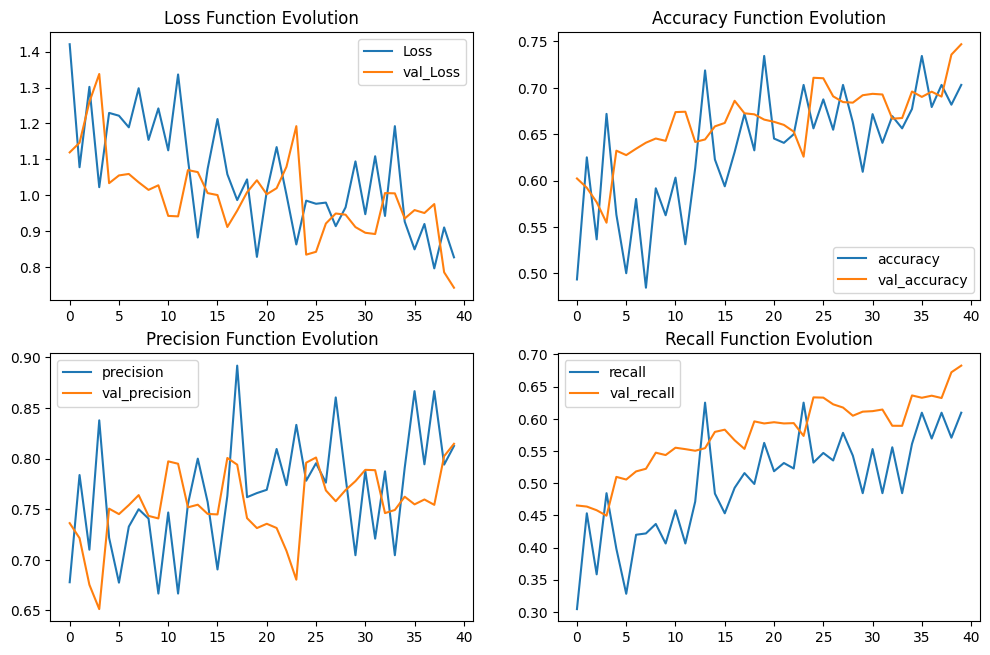

In [ ]:
# plt.figure(figsize=(12, 16))

# plt.subplot(4, 2, 1)
# plt.plot(r.history['loss'], label='Loss')
# plt.plot(r.history['val_loss'], label='val_Loss')
# plt.title('Loss Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 2)
# plt.plot(r.history['accuracy'], label='accuracy')
# plt.plot(r.history['val_accuracy'], label='val_accuracy')
# plt.title('Accuracy Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 3)
# plt.plot(r.history['precision'], label='precision')
# plt.plot(r.history['val_precision'], label='val_precision')
# plt.title('Precision Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 4)
# plt.plot(r.history['recall'], label='recall')
# plt.plot(r.history['val_recall'], label='val_recall')
# plt.title('Recall Function Evolution')
# plt.legend()

### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network